# Exploring data normalization and analysis in large TMT experimental designs
## Part 1 - Normalizations

### Phil Wilmarth, OHSU PSR Core, January 2018

## Overview: 
Many factors make data analyses challenging in experiments where more than one set of isobaric tag reagents are used. Even with up to 11 reagents available, many experiments require more replicates/conditions than can fit in one labeling. Three to five conditions (different groups, treatments, times, etc.) each with 3 to 5 replicates results in numbers of samples from 9 to 25. It can be difficult to squeeze a proper study design into just 11 samples.

Any series of complicated measurements is never going to be perfect. There will be many sources of variation in addition to the biological differences between groups. Are the measured differences between groups due to the biology or the other sources of variation? There are many methods for removing unwanted sources of variation such as inaccuracies in protein assays and pipetting errors. These are collectively known as normalization methods. 

The underlying concept behind normalization is that some samples (such as technical replicates, or biological replicates within one group) should be similar to each other based on some criteria. If these samples are not as similar as they should be, that extra variance may obscure the biological differences we are trying to see. If we can devise schemes and algorithms (normalizations) to make these similar samples more similar without removing or affecting biological differences, we can improve the power to measure what we want to measure.

A misconception in data normalization is that complicated, multi-step procedures will require just one normalization step. Let's explore a typical TMT experiment. We start with some biological experiment where each biological condition is well defined and that some number of replicates in each condition have been defined. We assume that any treatments and/or time courses were all done correctly. We assume that the protein samples were collected and processed carefully. Just getting to the "start" of a TMT labeling requires many steps that took effort to optimize. 

Having the set of protein samples is the starting point for the labeling protocol. We have to know how much protein is in each sample to aliquot the same amount of protein from each sample (this is effectively the first normalization step). That requires protein assays and pipetting. The proteins must be digested into peptides before labeling. Sometimes a peptide assay is done after digestion to make sure that the digestion was okay (this might result in another normalization step). The digested peptides are labeled with the TMT reagents. Sometimes the amounts of labeled peptides in each channel are checked with a short mass spec run to make sure the labeling reaction worked okay, and aliquot adjustments made so that the final mixture is more similar between channels (another normalization step). Next is the full-scale LC/MS experiment (often some sort of multi-dimensional separation) where deep sampling of the proteome is a typical goal. The total signal per channel can again be checked for consistency. Despite upstream corrections, the measured signal totals are seldom as identical as expected and will typically require additional adjustments during data analysis (more normalization steps). We will see below how the random sampling selection of peptides for MS2 analysis makes multiple TMT experiments difficult to combine without using a special IRS correction procedure (a specialized normalization step). 

If we successfully get to the point where we have a table of protein expression values for a set of biological samples, we may still have compositional bias that needs to be corrected. Since we process similar total amounts of material (protein or mRNA), changes in expression of a small number of highly abundant proteins can make all of the rest of the protein appear to be down regulated. Depending on your point of view, the data can be a few abundant proteins increasing in expression and other proteins being unchanged, or a large number of proteins decreasing in expression and a small number of abundant proteins being mostly unchanged. Normalization methods, such as the trimmed mean of M values (TMM), developed for RNA-Seq data, can remove compositional bias: 

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

To summarize, there are many experimental and analysis steps in these complicated measurements, and many have implicit or explicit associated normalizations. There are many software normalization algorithms that have been used in proteomics and an even larger number that have been developed for genomics. One strategy is to make the "size" of every sample the same since an equal amount of mRNA or protein is usually processed for each sample. Another strategy is to take something specific and make that "the same" between each sample. These "landmarks" can be the levels of housekeeping genes, the average or median signal, or the average or median expression ratio. These normalizations typically use a single multiplicative factor to adjust the samples to each other.

There are many other more complicated methods such as cyclic loess or quantile normalization that have more degrees of freedom and apply more complicated adjustment factors. In genomics, platform variability is well known, and this can result in rather interesting distortions between datasets that are referred to as "batch" effects. In many cases, these distortions can be recognized and corrected with more elaborate batch correction methods. Data can be corrected for these batch effects by normalization steps before statistical modeling is done. Alternatively, some statistical packages can incorporate batch factors into their models and may perform better with uncorrected data.

We are not doing a review of all possible normalization methods, though. We just want to learn how to analyze experiments using isobaric labeling when the study design needs more than 10 or 11 samples, and multiple TMT experiments have to be combined. We will explore how to analyze these experiments using the internal reference scaling (IRS) methodology that was first described in this publication:

> Plubell, D.L., Wilmarth, P.A., Zhao, Y., Fenton, A.M., Minnier, J., Reddy, A.P., Klimek, J., Yang, X., David, L.L. and Pamir, N., 2017. Extended multiplexing of tandem mass tags (TMT) labeling reveals age and high fat diet specific proteome changes in mouse epididymal adipose tissue. Molecular & Cellular Proteomics, 16(5), pp.873-890.

Plubell, et al. introduced a novel normalization methodology (IRS) capable of correcting the random MS2 sampling that occurs between TMT experiments. Analytes are sampled during their elution profile and the measured reporter ion signal intensity depends on the level of the analyte at the time of the sampling. This MS2 selection process can be modeled as a random sampling process:

> Liu, H., Sadygov, R.G. and Yates, J.R., 2004. A model for random sampling and estimation of relative protein abundance in shotgun proteomics. Analytical chemistry, 76(14), pp.4193-4201.

The random MS2 sampling affects the overall intensity of reporter ions, but not their relative intensities. The relative expression pattern of reporter ions is robust with respect to MS2 sampling. This random MS2 sampling creates a source of variation that is unique to isobaric tagging experiments. As we will see below, failure to correct for this source of variation makes combining data from multiple TMT experiments practically impossible. 

<br>

 ## Example dataset:
When testing new methodologies, it is helpful to work on a dataset where something is already known, and some safe assumptions can be made. This paper is a developmental time course study of mice lens and has publicaly available data: 
> Khan, S.Y., Ali, M., Kabir, F., Renuse, S., Na, C.H., Talbot, C.C., Hackett, S.F. and Riazuddin, S.A., 2018. Proteome Profiling of Developing Murine Lens Through Mass Spectrometry. Investigative Ophthalmology & Visual Science, 59(1), pp.100-107.

There were 2 embryonic time points and 4 post-natal time points (E15, E18, P0, P3, P6, and P9) each three days apart that were TMT labeled (6 channels in each experiment). There were many lenses pooled at each time point and the experiments were repeated three times as three independent TMT experiments. The instrument was a Thermo Fusion Lumos and the SPS MS3 method was used to get reporter ion signals with reduced interference. 

There were no common channels (standards or repeated samples) present in the three TMT experiments. In the publication by Plubell et al. where the IRS method was first described, duplicate channels of the same pooled reference mixtures were run in each TMT experiment and were used to match the protein reporter ion intensities between TMT experiments. That is the preferred experimental design. We will try and "mock up" a reference channel for each TMT experiment and perform a mock IRS method.

These are inbred laboratory mice and there are several lenses pooled at each time point in each TMT experiment. We can expect the three replicates at each time point to be pretty similar to each other (assuming good sample collection and processing). The same set of 6 time points were in each TMT experiment. If we average all 6 time points in each TMT experiment, this should be a good "mock" reference channel to use in the IRS procedure. 

We know a lot about mouse lenses from years of study. The central part of the lens is composed of fiber cells that contain a dramatic over-expression of a small number of lens-specific proteins called crystallins. Fiber cells are not metabolically active, no longer have organelles, and there is no cellular turnover in the lens. There is a monolayer of metabolically active epithelial cells on the anterior face of the spherical shaped lens. There is an outer region of the lens, called the cortex, where the cells undergo differentiation from epithelial cells to mature fiber cells. One simple model of lens protein expression with time is that the complement of cellular proteins from the epithelial cells (and some cortical cells) will be progressively diluted out by the accumulated crystallins. In mature lenses, the crystallins make up roughly 90% of the lens.

Supplemental File 1 in the above study contains the total protein reporter ion intensities for each protein (the rows) in each experiment (6 channels per experiment for 18 columns). The data were processed with Proteome Discoverer 2.1 (PD) and exported as text files. A mouse Swiss-Prot database was used to keep redundant peptides to a minimum. Maximum parsimony was used to group proteins. Peak height intensities (not the PD default signal/noise ratios) were used for the reporter ions. Note that a signal-to-noise ratio is a compressed unitless number and is not a valid quantitative measurement. PD sums all usable PSM (peptide spectrum match) reporter ion signals into total protein signals for each TMT experiment (summing over any first-dimension fractions).

## Load libraries and the dataset:
R script development was initially done using RStudio. This document was created as a Jupyter notebook using an R kernel. R libraries will need to be installed before loading the dataset. We will only work with proteins where reporter ion values were observed in all 3 experiments. We will do some column name cleanup and get some of the annotation information (gene symbols and protein accessions) set aside to add back later.

In [1]:
# Analysis of IOVS mouse lens data (Supplemental Table S01):
# Khan, Shahid Y., et al. "Proteome Profiling of Developing Murine Lens Through Mass Spectrometry."
# Investigative Ophthalmology & Visual Science 59.1 (2018): 100-107.

# load libraries
library(tidyverse) 
library(limma) 
library(edgeR) 
library(sva)

# read the Supplemental 01 file (saved as a CSV export from XLSX file)
data_start <- read_csv("iovs-58-13-55_s01.csv")

# filter out proteins not seen in all three runs
data_no_na <- na.omit(data_start)

# fix the column headers
col_headers <- colnames(data_no_na) 
col_headers <- str_replace(col_headers, " {2,3}", " ") 
col_headers <- str_replace(col_headers, "Reporter ion intensities ", "") 
colnames(data_no_na) <- col_headers

# save the annotations (gene symbol and protein accession) and remove from data frame
annotate_df <- data_no_na[1:2] 
data_raw <- as.data.frame(data_no_na[3:20]) 
row.names(data_raw) <- annotate_df$`Protein Accession No.`

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: mgcv
Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

This is mgcv 1.8-23. For overview type 'help("mgcv-package")'.
Loading required package: genefilter

Attaching package: ‘genefilter’

The following object is masked from ‘package:readr’:

    spec

Loading required package: BiocParallel
Parsed with column specification:
cols(
  .default = col_double(),
  `Gene Symbol (NCBI)` = col_character(),
  `Protein Accession No.` = col_character()
)
See spec(...) for full column specifications.



### Let's see what we have in the data frame:


In [2]:
head(data_raw)

E15_Set1   E18_Set1   P0_Set1    P3_Set1    P6_Set1    P9_Set1   
P24622 1069664652 1457114681 1179045944 1455372629 1289042085 1407632648
Q9JJU9  526906032  784281820  534395113  600416635  569878248  647355498
Q9WVJ5  586695635  792968077  553232976  626183065  528280042  578745749
P04345  315209709  488623202  362367811  433275153  396120791  445134422
P62696   30064315   43240455   25447349   95541340  199771510  368264651
Q61597  121970802  209140086  189655080  201060109  237678671  309076418
       E15_Set2    E18_Set2    P0_Set2    P3_Set2    P6_Set2    P9_Set2   
P24622 794413496.8 948014907.0 1937604914 1869740434 2319811405 1979600014
Q9JJU9 194176625.9 197270382.6  460870620  331488498  478119986  367960325
Q9WVJ5 480706341.9 350268581.8 1018230717  600709392  851756335  674769074
P04345 181105752.5 202759948.5  416298217  460506970  556686630  450709511
P62696    970485.4    965249.9   13289066   60115071  184639333  292264145
Q61597  29836712.7  27384410.0   78502992   78695122  139666562  131618214
       E15_Set3    E18_Set3  P0_Set3   P3_Set3   P6_Set3    P9_Set3  
P24622 504923157.8 799957030 694554606 815374345 1120186978 952547300
Q9JJU9 296834237.4 288048268 245193675 267307062  431955394 393248818
Q9WVJ5 411187998.3 472248038 337236872 342318702  616158187 521683037
P04345 140301513.8 235519864 218656765 244302151  333440543 284491654
P62696    413635.3   2577753   5953925  29244166   84402818 134267384
Q61597  45393640.0  94515836  92566739 117465776  175146797 170114753

## What do the raw (un-normalized) data distributions look like?
We will use box plots, a common way to summarize distributions, and distribution density plots to visualize the Log base 2 of the intensities. If the data distributions do not have well aligned box plots, the need for normalization would be indicated. The 6 samples from each TMT experiment are adjacent and in the same color, and each of the three TMT experiments are in different colors (red, green, and blue).

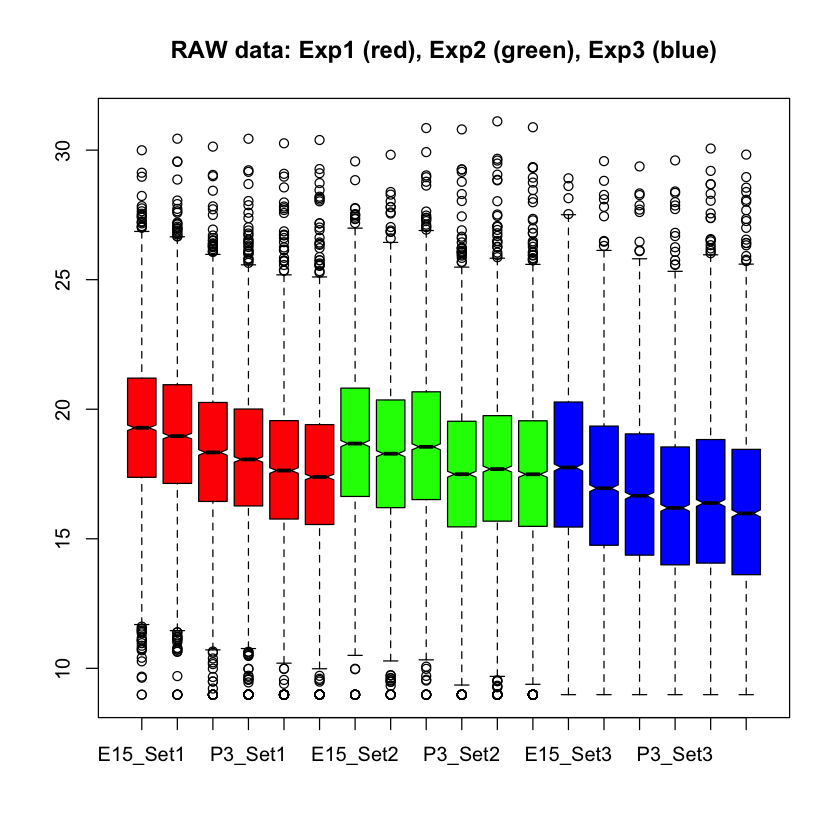

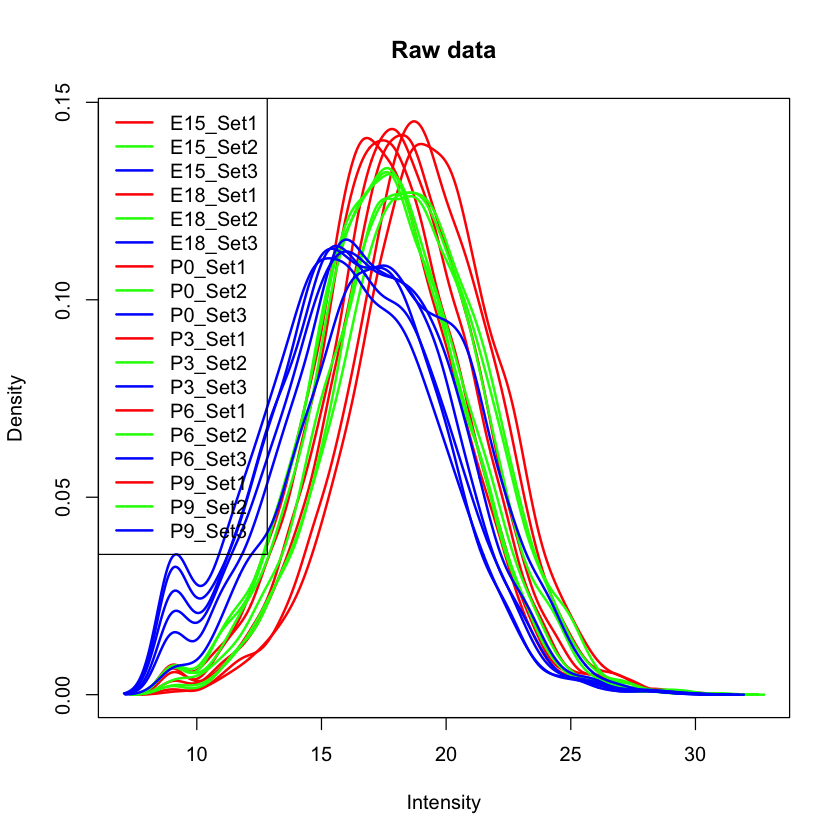

In [3]:
# let's see what the starting data look like
boxplot(log2(data_raw), col = rep(c("red", "green", "blue"), each = 6), 
        notch = TRUE, main = "RAW data: Exp1 (red), Exp2 (green), Exp3 (blue)")

# can also look at density plots (like a distribution histogram)
plotDensities(log2(data_raw), col = rep(c("red", "green", "blue"), 6), main = "Raw data")

In [4]:
# check the column totals (per channel sums)
format(round(colSums(data_raw), digits = 0), big.mark = ",")

E15_Set1         E18_Set1          P0_Set1          P3_Set1 
"15,454,863,217" "14,852,067,937" " 9,946,167,870" "10,047,936,585" 
         P6_Set1          P9_Set1         E15_Set2         E18_Set2 
" 8,553,796,614" " 9,083,779,828" "11,952,290,485" " 9,749,057,664" 
         P0_Set2          P3_Set2          P6_Set2          P9_Set2 
"14,558,974,664" " 9,631,496,297" "12,401,976,363" "10,883,266,433" 
        E15_Set3         E18_Set3          P0_Set3          P3_Set3 
" 8,997,954,961" " 6,613,312,876" " 5,462,406,449" " 5,075,004,896" 
         P6_Set3          P9_Set3 
" 7,313,410,134" " 6,298,792,787"

## Do we need to do some data normalization?
The above box plots and density distributions are not well aligned. Let's check the total signal in each channel for the 18 samples (below). There was supposed to be the same amount of protein labeled in each sample. We should have the total signals in each channel summing to the same value. We have significant differences that we can correct with some basic normalizing. We can average the numbers below and compute normalization factors to make the sums end up the same.

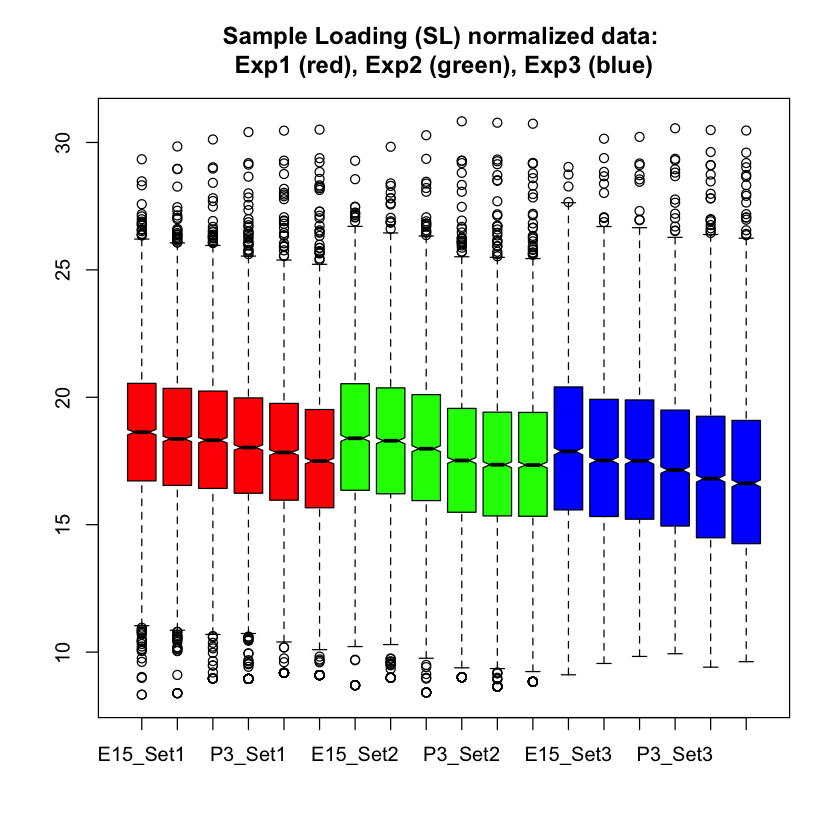

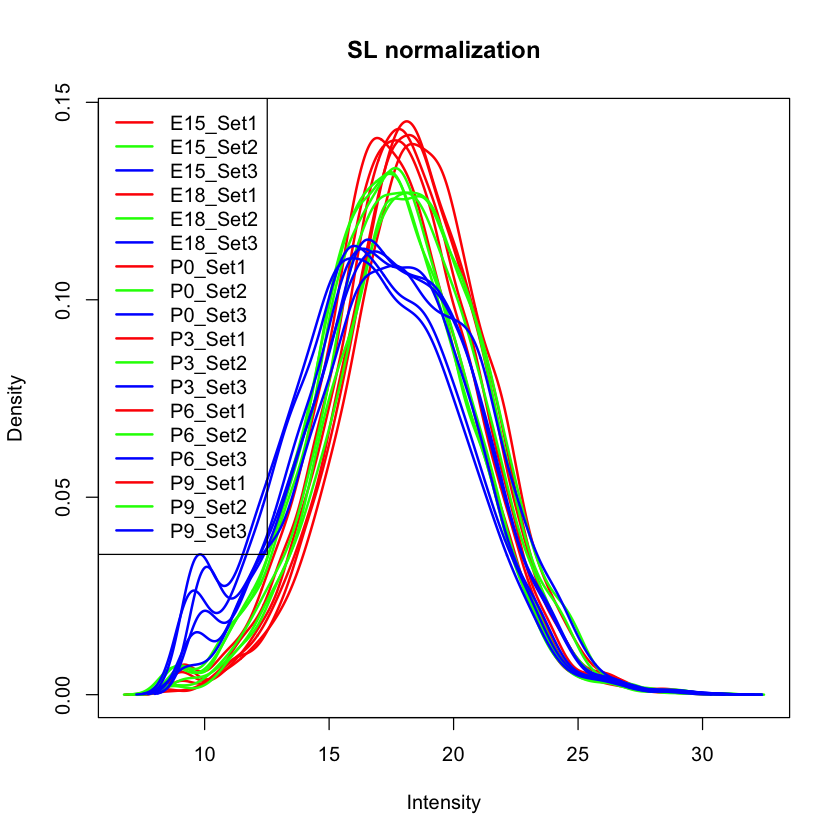

In [5]:
# separate the TMT data by experiment
# we do not need to do this for the normalization factor calculation here,
# but we will need these data frames for the IRS step below.
exp1_raw <- data_raw[c(1:6)]
exp2_raw <- data_raw[c(7:12)]
exp3_raw <- data_raw[c(13:18)]

# first basic normalization is to adjust each TMT experiment to equal signal per channel
# figure out the global scaling value
target <- mean(c(colSums(exp1_raw), colSums(exp2_raw), colSums(exp3_raw)))

# do the sample loading normalization before the IRS normalization
# there is a different correction factor for each column
norm_facs <- target / colSums(exp1_raw)
exp1_sl <- sweep(exp1_raw, 2, norm_facs, FUN = "*")
norm_facs <- target / colSums(exp2_raw)
exp2_sl <- sweep(exp2_raw, 2, norm_facs, FUN = "*")
norm_facs <- target / colSums(exp3_raw)
exp3_sl <- sweep(exp3_raw, 2, norm_facs, FUN = "*")

# make a pre-IRS data frame after sample loading normalizations
data_sl <- cbind(exp1_sl, exp2_sl, exp3_sl)

# see what the SL normalized data look like
boxplot(log2(data_sl), col = rep(c("red", "green", "blue"), each = 6), 
        notch = TRUE, main = "Sample Loading (SL) normalized data: \nExp1 (red), Exp2 (green), Exp3 (blue)")

# can also look at density plots (like a distribution histogram)
plotDensities(log2(data_sl), col = rep(c("red", "green", "blue"), 6), main = "SL normalization")

In [6]:
# check the columnn totals
format(round(colSums(data_sl), digits = 0), big.mark = ",")

E15_Set1        E18_Set1         P0_Set1         P3_Set1         P6_Set1 
"9,826,475,337" "9,826,475,337" "9,826,475,337" "9,826,475,337" "9,826,475,337" 
        P9_Set1        E15_Set2        E18_Set2         P0_Set2         P3_Set2 
"9,826,475,337" "9,826,475,337" "9,826,475,337" "9,826,475,337" "9,826,475,337" 
        P6_Set2         P9_Set2        E15_Set3        E18_Set3         P0_Set3 
"9,826,475,337" "9,826,475,337" "9,826,475,337" "9,826,475,337" "9,826,475,337" 
        P3_Set3         P6_Set3         P9_Set3 
"9,826,475,337" "9,826,475,337" "9,826,475,337"

## Correcting for sample loading helped but medians are not aligned
The numbers above show that the sample loading (SL) normalization did make the column totals the same. However, we still have a systematic decrease in median value as a function of developmental age within each TMT experiment (the box plots are not in a straight horizontal line). This makes sense for this system because we know that the lens will have greater and greater amounts of highly abundant crystallins as the lens matures. This will dilute the proteins originating from the epithelial cells and cortex. We expect the signal for the median protein, which will not be one of the over-expressed lens proteins, to decrease. This sounds like the kind of compositional bias that the TMM normalization was designed to correct. Let's see if that is the case.

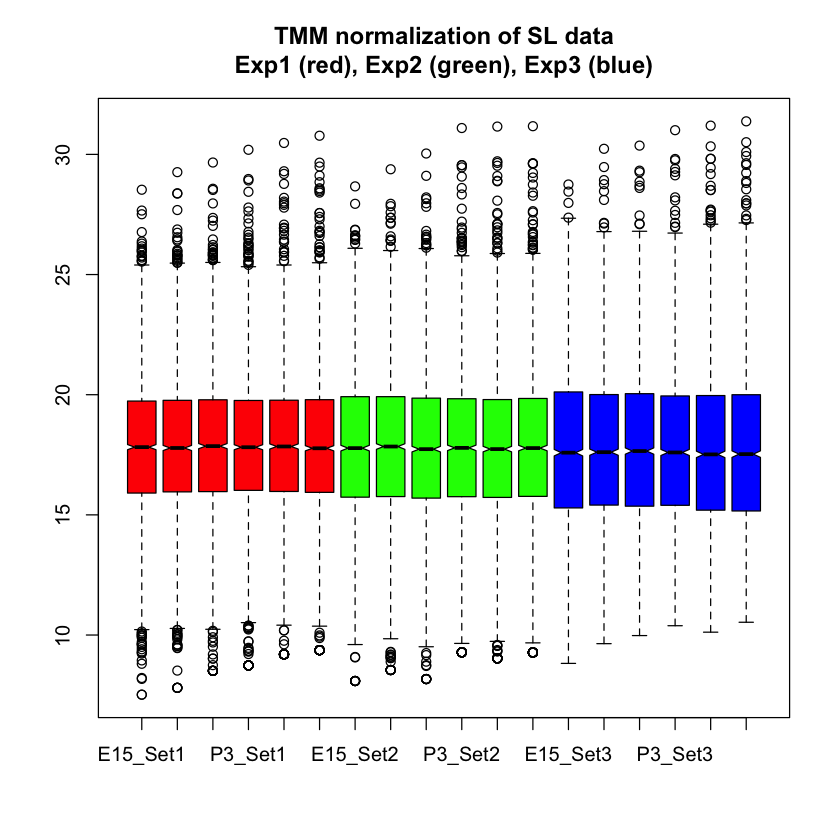

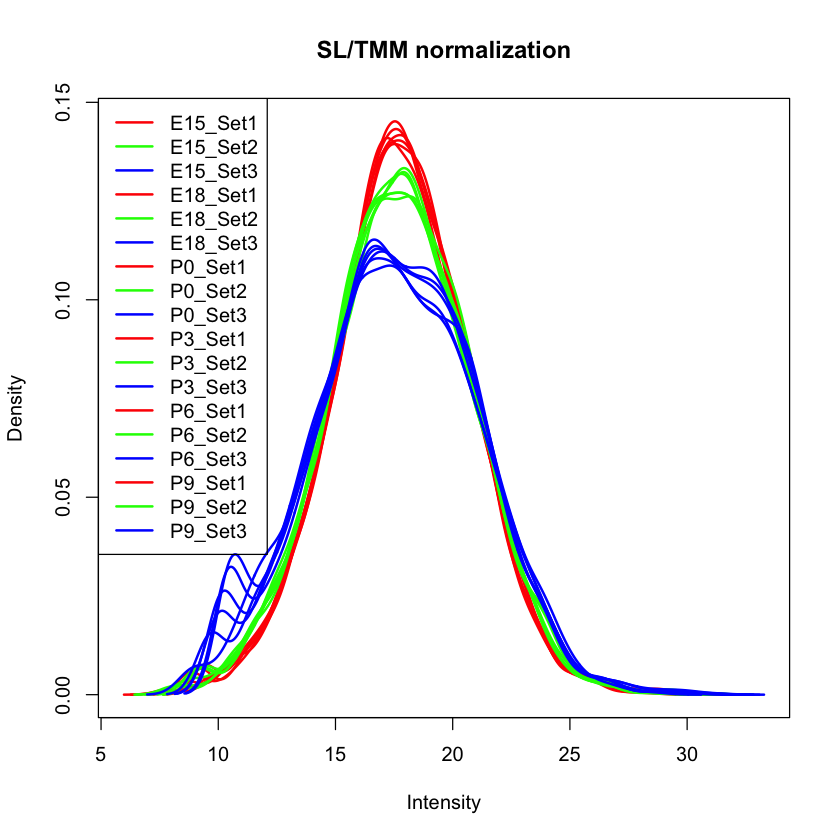

In [7]:
# do TMM on raw data - we use it later for CV analyses
raw_tmm <- calcNormFactors(data_raw)
data_raw_tmm <- sweep(data_raw, 2, raw_tmm, FUN = "/") # raw data after TMM on original scale

# perform TMM on the SL-normed data and visualize resulting distributions
sl_tmm <- calcNormFactors(data_sl)
data_sl_tmm <- sweep(data_sl, 2, sl_tmm, FUN = "/") # data after SL and TMM on original scale

boxplot(log2(data_sl_tmm), notch = TRUE, col = rep(c("red", "green", "blue"), each = 6), 
        main = "TMM normalization of SL data\nExp1 (red), Exp2 (green), Exp3 (blue)")

# can also look at density plots (like a distribution histogram)
plotDensities(log2(data_sl_tmm), col = rep(c("red", "green", "blue"), 6), main = "SL/TMM normalization")

## TMM normalization aligns the centers of the distributions
The box plots show that TMM normalization performs as expected and makes the centers of the distributions more similar. However, the column sum numbers below are now different (as might be expected), showing an increase with increasing developmental time. It is not obvious whether SL normalization alone is the better way to normalized data from the developing lens, or if the compositional correction of TMM is more appropriate. One or both methods may be useful depending on the questions being asked.

Different ways to view how similar the samples are to each other give us different insights. After TMM normalization, the box plots look very similar. The density plots indicated that are still some aspects of the data that are not yet the same (some wiggles and dips). We can assume that the lens proteomes will differ significantly over this time course. This is an active range of early mouse development. There are many lenses pooled for each time point and inbred mice are quite similar, so we can expect that the biological replicates at each time point should be similar. We would, therefore, expect our samples to cluster by developmental times. Let's see if that is the case. There is a multidimensional scaling (MDS) function available in limma that is like principal component analysis.  

In [8]:
# check column totals
format(round(colSums(data_sl_tmm), digits = 0), big.mark = ",")

E15_Set1         E18_Set1          P0_Set1          P3_Set1 
" 5,598,164,472" " 6,555,683,977" " 7,165,320,124" " 8,466,306,076" 
         P6_Set1          P9_Set1         E15_Set2         E18_Set2 
" 9,903,654,112" "11,869,530,015" " 6,419,425,402" " 7,189,331,413" 
         P0_Set2          P3_Set2          P6_Set2          P9_Set2 
" 8,274,743,343" "11,829,810,773" "12,806,613,561" "13,308,015,224" 
        E15_Set3         E18_Set3          P0_Set3          P3_Set3 
" 8,031,737,789" "10,430,257,416" "10,877,087,140" "13,430,009,209" 
         P6_Set3          P9_Set3 
"16,065,284,740" "18,420,064,210"

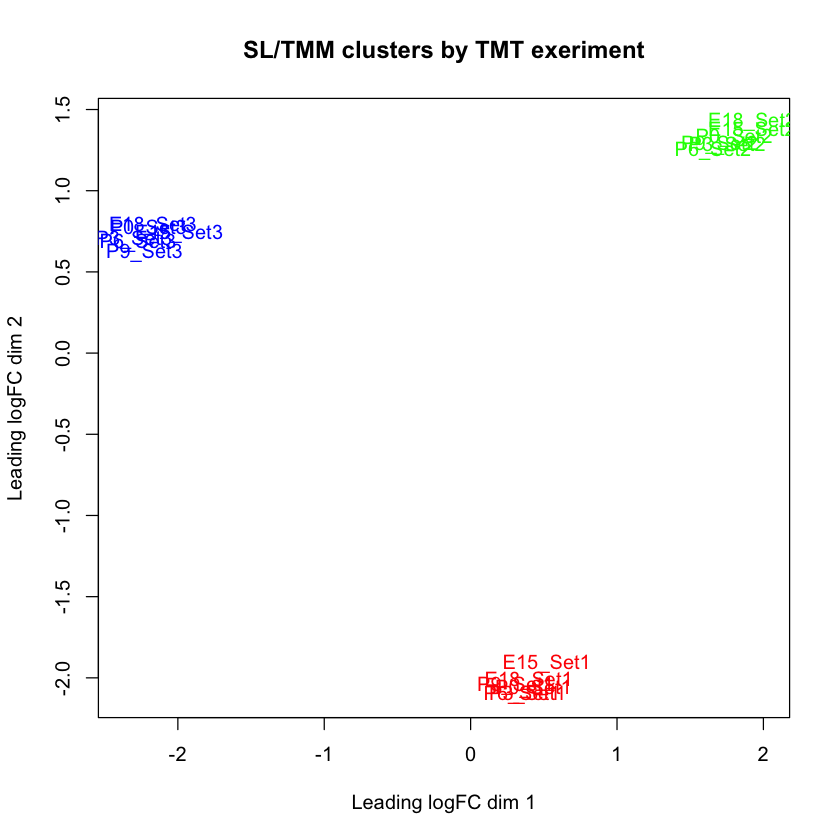

In [9]:
# see how things cluster now that we have nice boxplots and density plots
plotMDS(log2(data_sl_tmm), col = rep(c("red", "green", "blue"), each = 6), main = "SL/TMM clusters by TMT experiment")

## Houston, we have a problem
Despite applying two sensible normalizations that greatly improved the box plot and density distributions, we have an unexpected very strong clustering by TMT experiment. If we explored additional components in the multi-dimensional scaling, we can see the developmental time points grouping as expected. We know that isobaric labeling is very precise when comparing intensities from the same instrument scan. We know that the instrument selects eluting analytes in a random fashion. Is it the similarity of reporter ion channels per scan within each TMT experiment that is behind the above clustering where time points within each TMT experiment seem more similar than the same time points between TMT experiments? Is this what IRS is designed to correct?

IRS relies on there being something identical (or very similar) being measured in each TMT experiment. That is the "internal reference" part. A pooled sample made up of aliquots of protein from all samples in the experiment works particularly well. If we measure exactly the same protein sample (in a given channel) in each TMT experiment, the set of protein intensities should be exactly the same (in a perfect world). The IRS procedure makes different measurements of the same things all exactly the same and puts all of the reporter ions on the same "intensity scale". Using two channels in each TMT to measure the internal standard is worth the extra channel because the average of two values is more stable than a single measurement. The final normalized data will only be as accurate as the internal reference standard measurements. The diagram below outlines the procedure:

<img src="irs_diagram.png">

This lens data set does not have the correct study design (common pooled standards) that was described in Plubell, et al. As was mentioned above, there are multiple mice lenses at each time point and inbred mice have low biological variability. We can safely assume that averaging over all time points in each TMT experiment should be a good proxy for a reference channel. We can perform the IRS method by creating a "mock" reference channel. For each TMT experiment, we will compute the reporter ion average over the 6 time points for each protein. For each protein, we will have 3 reference intensities, one from each TMT. We can compute the average reference intensity and compute 3 factors to adjust the reference value in each TMT experiment to the average. We will multiply that value for each TMT experiment times each of the 6 reporter ion channels for that TMT experiment. 

Each TMT experiment gets its own correction factors independently for each protein. Each protein is corrected between the three TMT experiments independently of all other proteins. There is no modeling in the procedure. Scaling factors are directly computed. Let's do the IRS corrections (there are pretty simple to compute in Excel, R, or pandas).

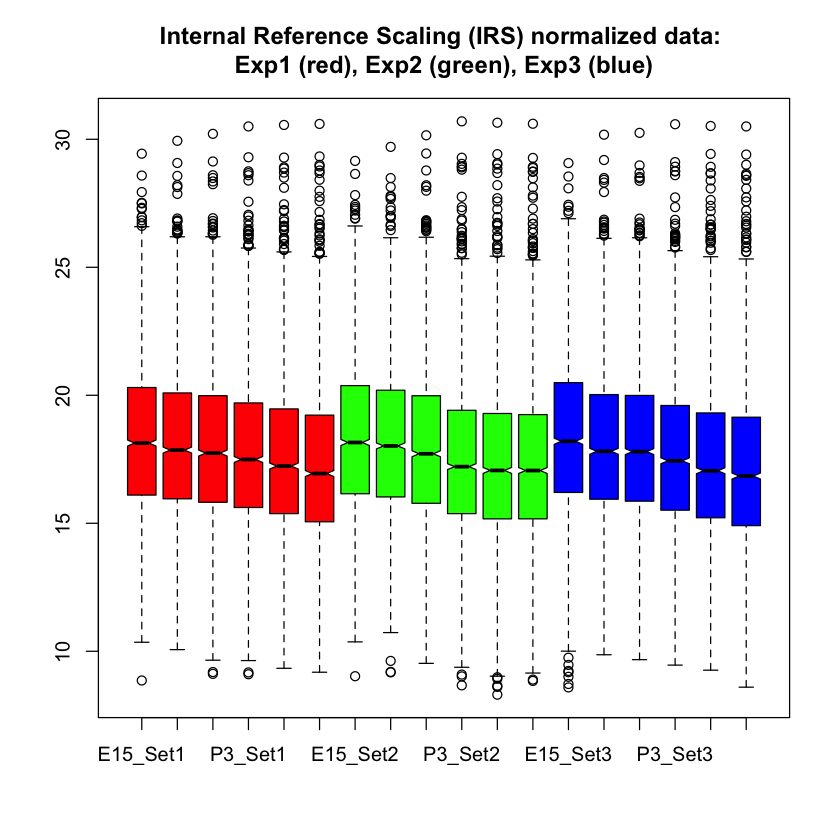

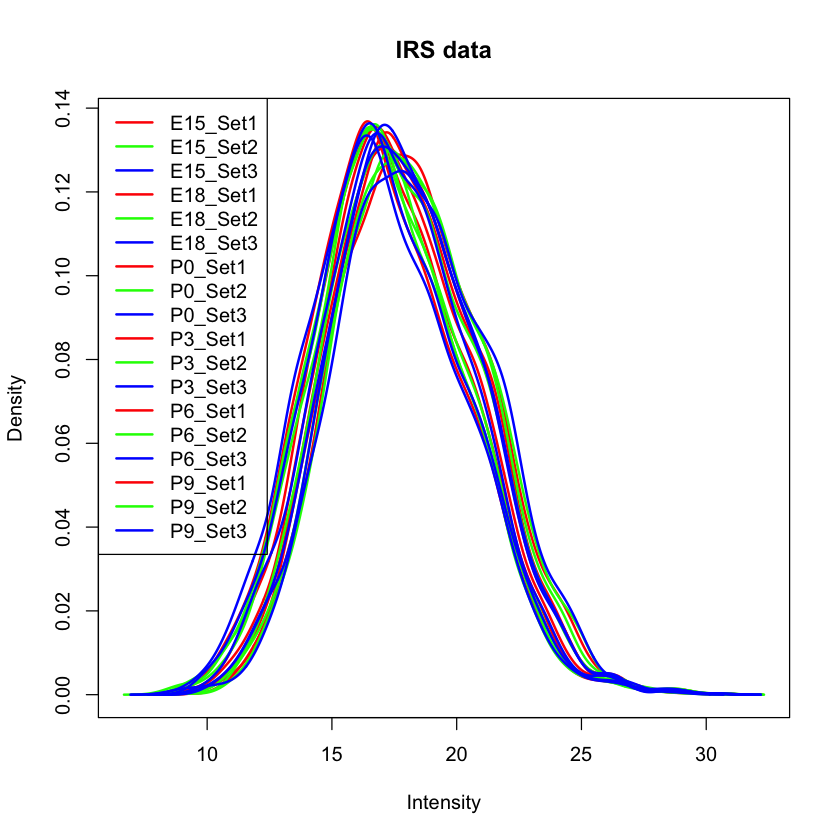

In [10]:
# make new data frame with row sums from each frame
irs <- tibble(rowSums(exp1_sl), rowSums(exp2_sl), rowSums(exp3_sl))
colnames(irs) <- c("sum1", "sum2", "sum3")

# get the geometric average intensity for each protein
irs$average <- apply(irs, 1, function(x) exp(mean(log(x))))

# compute the scaling factor vectors
irs$fac1 <- irs$average / irs$sum1
irs$fac2 <- irs$average / irs$sum2
irs$fac3 <- irs$average / irs$sum3

# make new data frame with IRS normalized data
data_irs <- exp1_sl * irs$fac1
data_irs <- cbind(data_irs, exp2_sl * irs$fac2)
data_irs <- cbind(data_irs, exp3_sl * irs$fac3)
    
# see what the IRS data look like
boxplot(log2(data_irs), col = rep(c("red", "green", "blue"), each = 6), 
        notch = TRUE, main = "Internal Reference Scaling (IRS) normalized data: \nExp1 (red), Exp2 (green), Exp3 (blue)")

# can also look at density plots (like a distribution histogram)    
plotDensities(log2(data_irs), col = rep(c("red", "green", "blue"), 6), main = "IRS data")    

## Box plots and density plots seem similar to SL plots

The box plots for IRS look similar to the situation after the SL normalization. The density plots are also similar, although some of the funny distortions are now gone. The gross features of the distributions do not seem much improved. The column totals below are similar (but not identical) across the samples. Remember that we did not make **each channel** the same for each protein, we made the 6-channel **average** the same. That leaves a little wiggle room for the individual channels. We have the same decrease in median intensity with developmental age present in the box plots as before, so we can add a TMM normalization step.

In [11]:
# check column totals
format(round(colSums(data_irs), digits = 0), big.mark = ",")

E15_Set1        E18_Set1         P0_Set1         P3_Set1         P6_Set1 
"9,270,664,774" "9,363,761,294" "9,451,622,436" "9,531,837,394" "9,537,837,657" 
        P9_Set1        E15_Set2        E18_Set2         P0_Set2         P3_Set2 
"9,566,996,326" "9,253,060,468" "9,135,830,721" "9,597,066,116" "9,528,757,306" 
        P6_Set2         P9_Set2        E15_Set3        E18_Set3         P0_Set3 
"9,640,979,074" "9,567,026,196" "9,668,711,403" "9,490,335,801" "9,425,086,706" 
        P3_Set3         P6_Set3         P9_Set3 
"9,389,657,787" "9,353,757,771" "9,395,170,413"

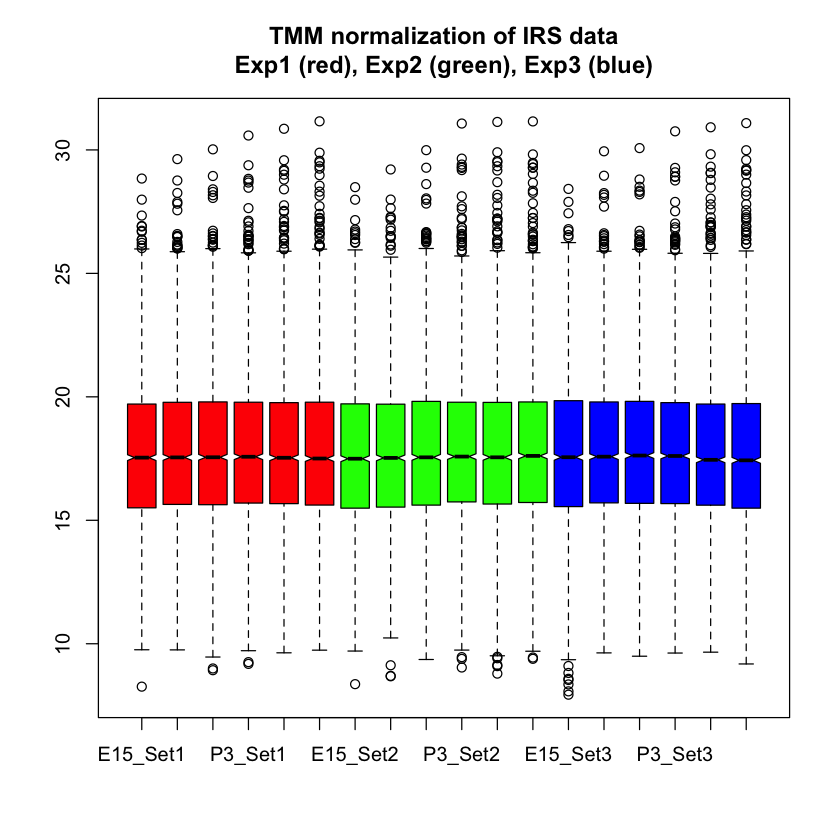

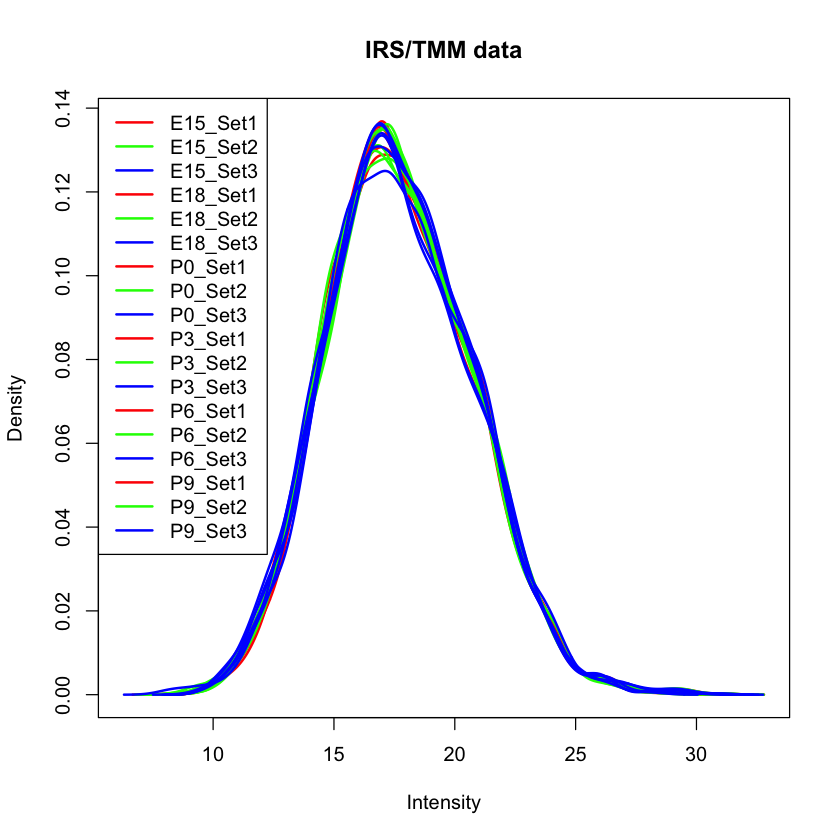

In [12]:
# this is data after SL, IRS, and TMM normalized on original scale
irs_tmm <- calcNormFactors(data_irs)
data_irs_tmm <- sweep(data_irs, 2, irs_tmm, FUN = "/") 

# see if box plots are aligned
boxplot(log2(data_irs_tmm), notch = TRUE, col = rep(c("red", "green", "blue"), each = 6), 
        main = "TMM normalization of IRS data\nExp1 (red), Exp2 (green), Exp3 (blue)")

# can also look at density plots (like a distribution histogram)
plotDensities(log2(data_irs_tmm), col = rep(c("red", "green", "blue"), 6), main = "IRS/TMM data")

## Yeah, Baby! Box plots and density plots are very similar between samples
We now have very nice-looking box plots and density plots. However, the distribution centers and widths are not too different in appearance from the SL/TMM situation. Has the IRS step really done something fundamentally different to the data? The TMM corrections have again changed the column totals as we saw above. Has the clustering situation changed? Do the samples still group by TMT experiment? 

In [13]:
# check the column totals
format(round(colSums(data_irs_tmm), digits = 0), big.mark = ",")

E15_Set1         E18_Set1          P0_Set1          P3_Set1 
" 6,133,528,888" " 7,539,704,663" " 8,288,018,716" "10,084,892,119" 
         P6_Set1          P9_Set1         E15_Set2         E18_Set2 
"11,721,900,635" "14,087,391,733" " 5,844,991,306" " 6,483,668,518" 
         P0_Set2          P3_Set2          P6_Set2          P9_Set2 
" 8,554,025,666" "12,297,741,229" "13,500,902,123" "13,982,532,410" 
        E15_Set3         E18_Set3          P0_Set3          P3_Set3 
" 6,161,243,698" " 8,065,556,392" " 8,334,587,175" "10,523,008,174" 
         P6_Set3          P9_Set3 
"12,316,438,220" "14,082,368,538"

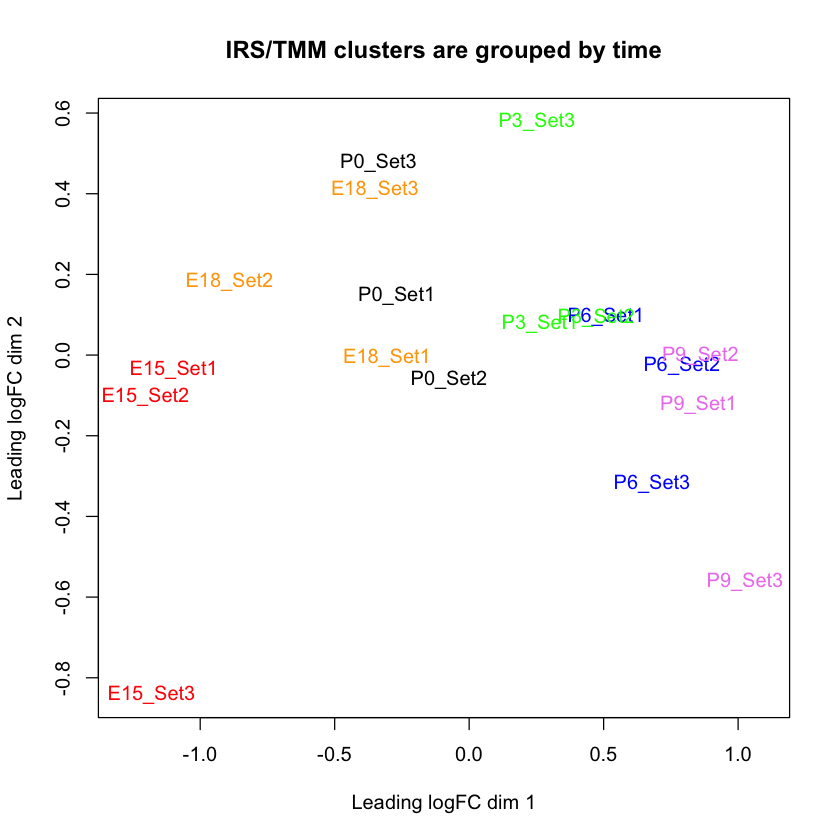

In [14]:
# see how things cluster after IRS plus TMM
col_vec <- c("red", "orange", "black", "green", "blue", "violet")
plotMDS(log2(data_irs_tmm), col = col_vec, main = "IRS/TMM clusters are grouped by time")

## IRS looks like it works, but are we just re-inventing the wheel?
The cluster plot above shows that the samples now group by biological factor (developmental time points) rather than some arbitrary external factor (the TMT experiment). In genomics, they might say that the different TMT experiments look like different "batches", and that IRS is just another batch correction method. **Been there done that...** Since we have our data in R, we can apply one of the main batch correction tools used in genomics called ComBat. It uses an empirical Bayes method to remove batch effects. Let's run ComBat and see how it compares to IRS. We have to supply some experimental design details to ComBat.
> Johnson, W.E., Li, C. and Rabinovic, A., 2007. Adjusting batch effects in microarray expression data using empirical Bayes methods. Biostatistics, 8(1), pp.118-127.

In [15]:
# is IRS just another "batch" correction?
# some experimental design setup for ComBat
(design <- read.csv("design.csv")) # look at the dataframe
design$group <- factor(design$group, levels = c("early", "middle", "late"))
mod <- model.matrix(~ group, data = design)
batch <- design$batch

# run ComBat as alternative to IRS
# NOTE: SL norm is probably better to do before applying the batch corection
data_combat <- ComBat(dat = data_sl, batch = batch, mod = mod, par.prior = TRUE)
par(mfrow = c(1, 1)) # any plotting in the ComBat call leaves plots as 2x2

sample times group  batch
1   1     E15   early  1    
2   2     E18   early  1    
3   3     P0    middle 1    
4   4     P3    middle 1    
5   5     P6    late   1    
6   6     P9    late   1    
7   7     E15   early  2    
8   8     E18   early  2    
9   9     P0    middle 2    
10 10     P3    middle 2    
11 11     P6    late   2    
12 12     P9    late   2    
13 13     E15   early  3    
14 14     E18   early  3    
15 15     P0    middle 3    
16 16     P3    middle 3    
17 17     P6    late   3    
18 18     P9    late   3

Found3batches
Adjusting for2covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



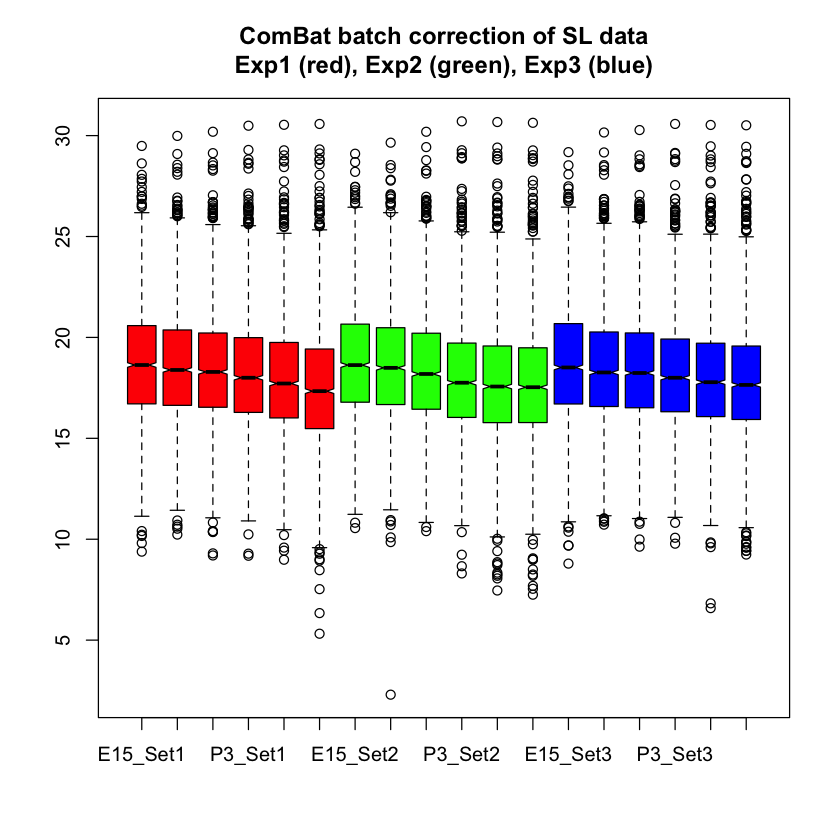

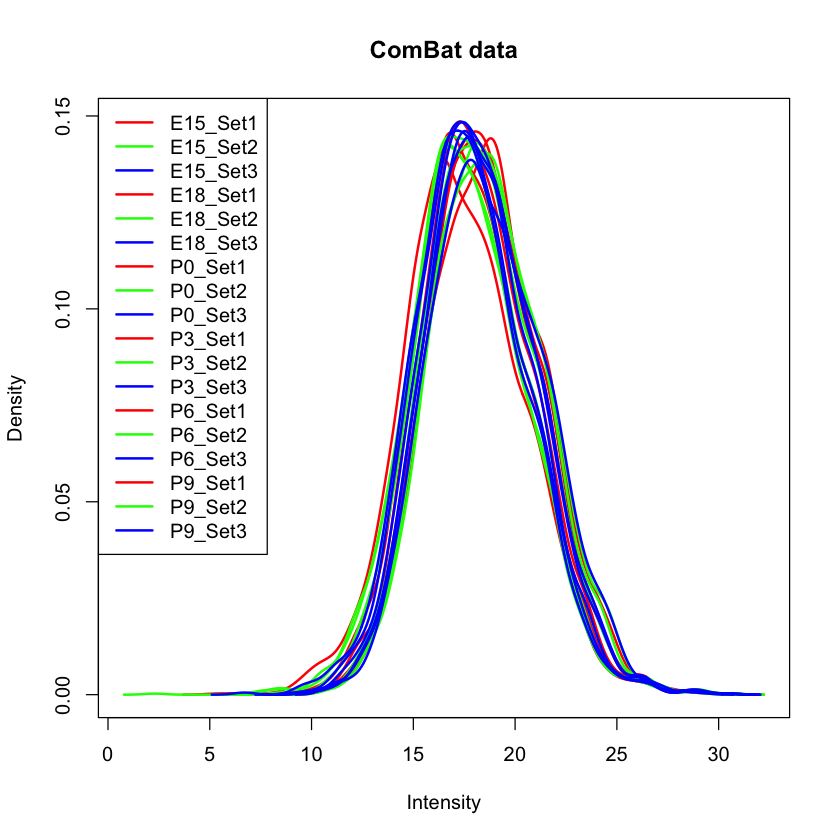

In [16]:
# ComBat introduces some negative corrected counts that we need to fix
data_combat <-  data_combat[apply(data_combat, 1, function(x) all(x >= 0)), ] 

# usual box plot views
boxplot(log2(data_combat), notch = TRUE, col = rep(c("red", "green", "blue"), each = 6), 
        main = "ComBat batch correction of SL data\nExp1 (red), Exp2 (green), Exp3 (blue)")

# can also look at density plots (like a distribution histogram)
plotDensities(log2(data_combat), col = rep(c("red", "green", "blue"), 6), main = "ComBat data")

In [17]:
# check the column totals
format(round(colSums(data_combat), digits = 0), big.mark = ",")

E15_Set1        E18_Set1         P0_Set1         P3_Set1         P6_Set1 
"9,232,322,651" "9,389,755,532" "9,486,895,559" "9,420,590,047" "9,234,794,326" 
        P9_Set1        E15_Set2        E18_Set2         P0_Set2         P3_Set2 
"9,034,639,995" "9,430,520,438" "9,070,631,706" "9,678,574,350" "9,446,732,895" 
        P6_Set2         P9_Set2        E15_Set3        E18_Set3         P0_Set3 
"9,327,759,576" "9,108,056,974" "9,412,911,372" "9,499,349,082" "9,562,996,659" 
        P3_Set3         P6_Set3         P9_Set3 
"9,438,768,333" "9,345,980,234" "9,196,859,104"

## Combat and IRS look very similar

Box plots, density plots, and column totals are very similar in appearance after IRS or after ComBat. We can remove the difference in ComBat box plot medians with a TMM step. 

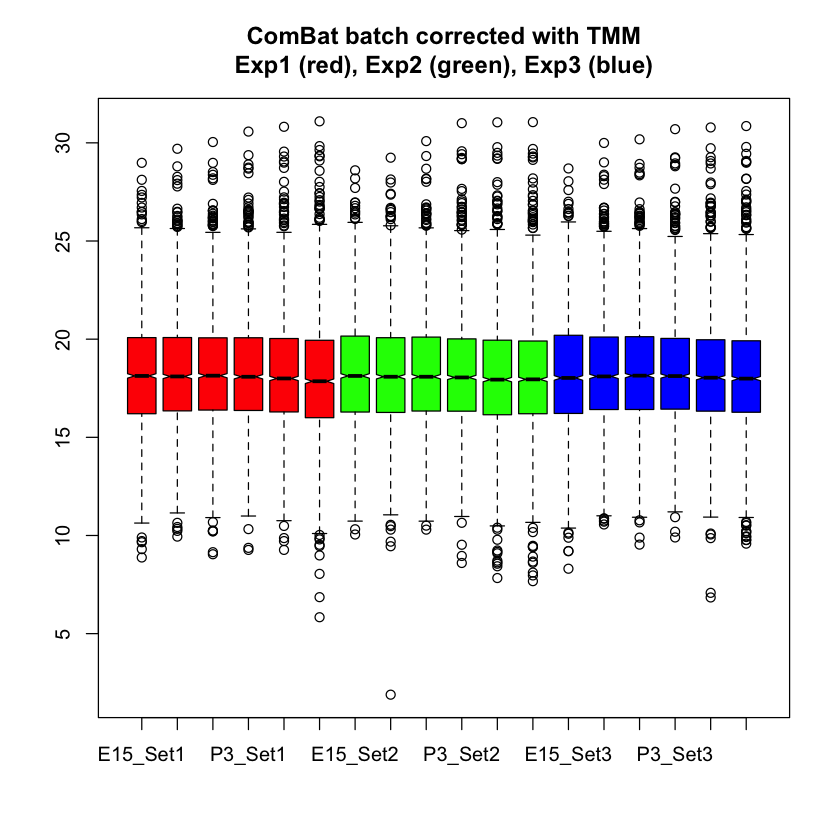

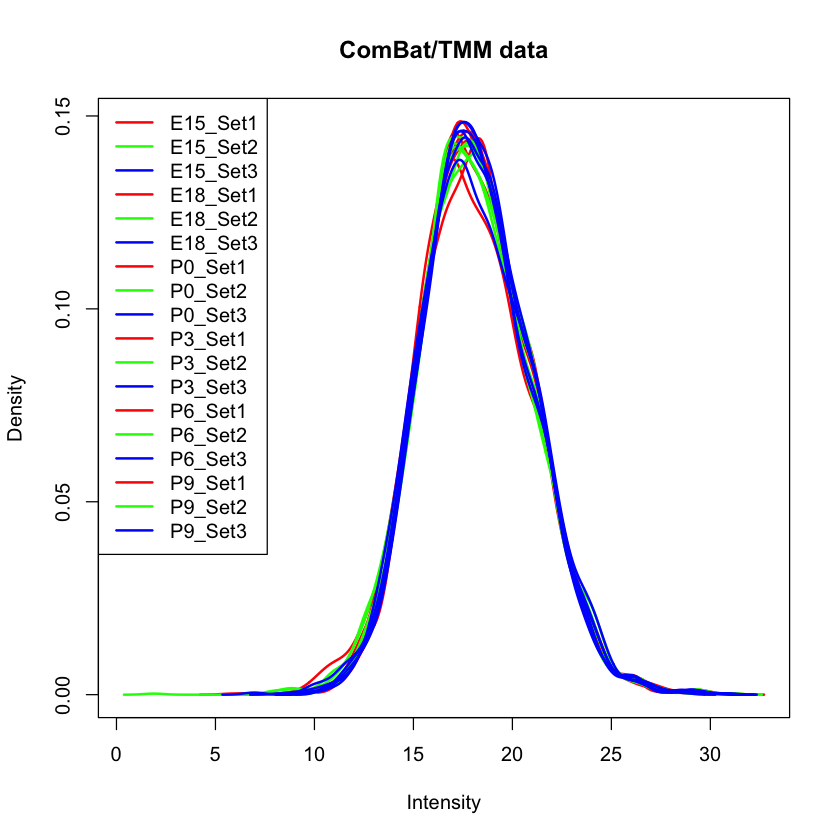

In [18]:
# apply TMM normalization to the ComBat-corrected data
combat_tmm <- calcNormFactors(data_combat)
data_combat_tmm <- sweep(data_combat, 2, combat_tmm, FUN = "/")

# look at the box plots
boxplot(log2(data_combat_tmm), notch = TRUE, col = rep(c("red", "green", "blue"), each = 6), 
        main = "ComBat batch corrected with TMM\nExp1 (red), Exp2 (green), Exp3 (blue)")

# can also look at density plots (like a distribution histogram)
plotDensities(log2(data_combat_tmm), col = rep(c("red", "green", "blue"), 6), main = "ComBat/TMM data")

E15_Set1         E18_Set1          P0_Set1          P3_Set1 
" 6,503,039,955" " 7,697,075,331" " 8,548,449,366" " 9,982,302,748" 
         P6_Set1          P9_Set1         E15_Set2         E18_Set2 
"11,231,914,140" "12,942,104,633" " 6,661,521,248" " 6,846,089,753" 
         P0_Set2          P3_Set2          P6_Set2          P9_Set2 
" 9,015,325,474" "11,594,347,270" "12,080,920,552" "12,193,046,581" 
        E15_Set3         E18_Set3          P0_Set3          P3_Set3 
" 6,724,722,933" " 8,497,532,579" " 8,949,091,023" "10,249,911,130" 
         P6_Set3          P9_Set3 
"11,168,061,483" "11,674,746,154"

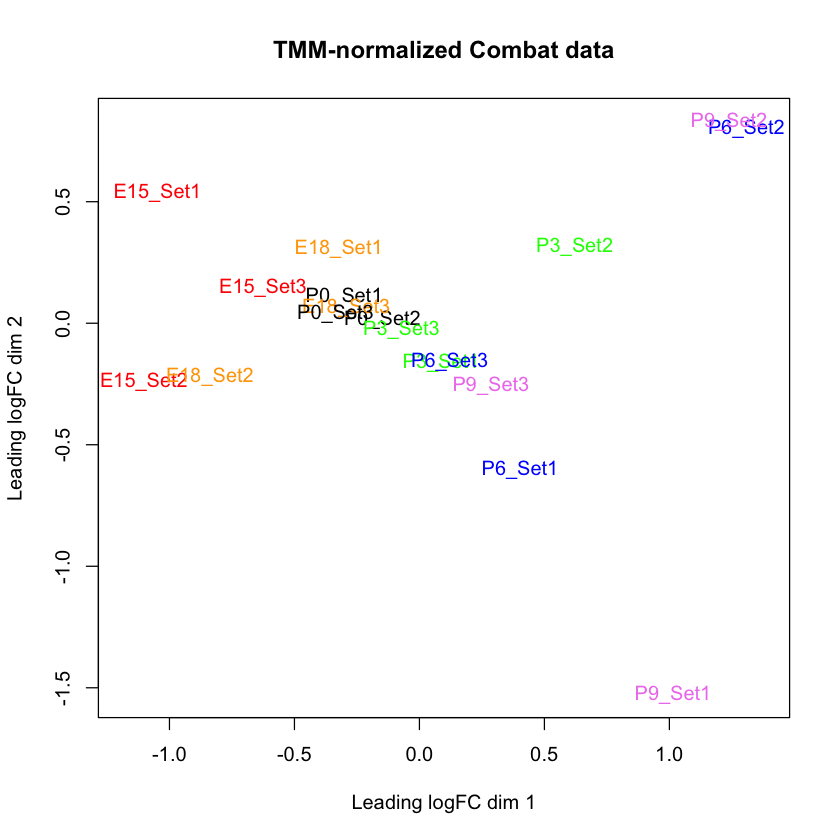

In [19]:
# check column totals and clustering
format(round(colSums(data_combat_tmm), digits = 0), big.mark = ",")
plotMDS(log2(data_combat_tmm), col = col_vec, main = "TMM-normalized Combat data")

## There is no clustering by TMT experiment after ComBat
Column totals after ComBat and TMM look like they did after IRS and TMM. The clustering of ComBat-corrected data does not have any TMT experiment grouping, although the clustering and separation by developmental time seems weaker compared to IRS. 

Box plots and density plots above after all of the different normalization steps are really showing aspects of the distribution of **all** 3155 proteins. The multi-dimensional scaling plots are a little more affected by the behavior of individual proteins. Other than some color coding in the MDS plots, we have not made any use of the study design. We know that the three replicates at each time point should be similar to each other (and that different time points should be different from each other). We can compute coefficients of variance (CVs) for each protein at each time point and see what those distributions look like. What we want is repeated measures for **each** protein at a given developmental time point to be as similar as possible. 

In [20]:
# function computes CVs per time point
make_CVs <- function(df) {
  # separate by time points
  E15 <- df[c(1, 7, 13)]
  E18 <- df[c(2, 8, 14)]
  P0 <- df[c(3, 9, 15)]
  P3 <- df[c(4, 10, 16)]
  P6 <- df[c(5, 11, 17)]
  P9 <- df[c(6, 12, 18)]

  # compute averages, standard deviations, and CVs
  E15$ave <- rowMeans(E15)
  E15$sd <- apply(E15[1:3], 1, sd)
  E15$cv <- 100 * E15$sd / E15$ave
  E18$ave <- rowMeans(E18)
  E18$sd <- apply(E18[1:3], 1, sd)
  E18$cv <- 100 * E18$sd / E18$ave
  P0$ave <- rowMeans(P0)
  P0$sd <- apply(P0[1:3], 1, sd)
  P0$cv <- 100 * P0$sd / P0$ave
  P3$ave <- rowMeans(P3)
  P3$sd <- apply(P3[1:3], 1, sd)
  P3$cv <- 100 * P3$sd / P3$ave
  P6$ave <- rowMeans(P6)
  P6$sd <- apply(P6[1:3], 1, sd)
  P6$cv <- 100 * P6$sd / P6$ave
  P9$ave <- rowMeans(P9)
  P9$sd <- apply(P9[1:3], 1, sd)
  P9$cv <- 100 * P9$sd / P9$ave

  # save results in 3 data frames and put into a list
  ave_df <- data.frame(E15$ave, E18$ave, P0$ave, P3$ave, P6$ave, P9$ave)
  sd_df <- data.frame(E15$sd, E18$sd, P0$sd, P3$sd, P6$sd, P9$sd)
  cv_df <- data.frame(E15$cv, E18$cv, P0$cv, P3$cv, P6$cv, P9$cv)
  return(list(ave_df, sd_df, cv_df))
}

### Compare the CV distributions for the different normalized data
We can compare CV distributions for the original data, after sample loading normalization, after the IRS procedure, or after ComBat batch corrections. We will apply the TMM normalization in all cases.

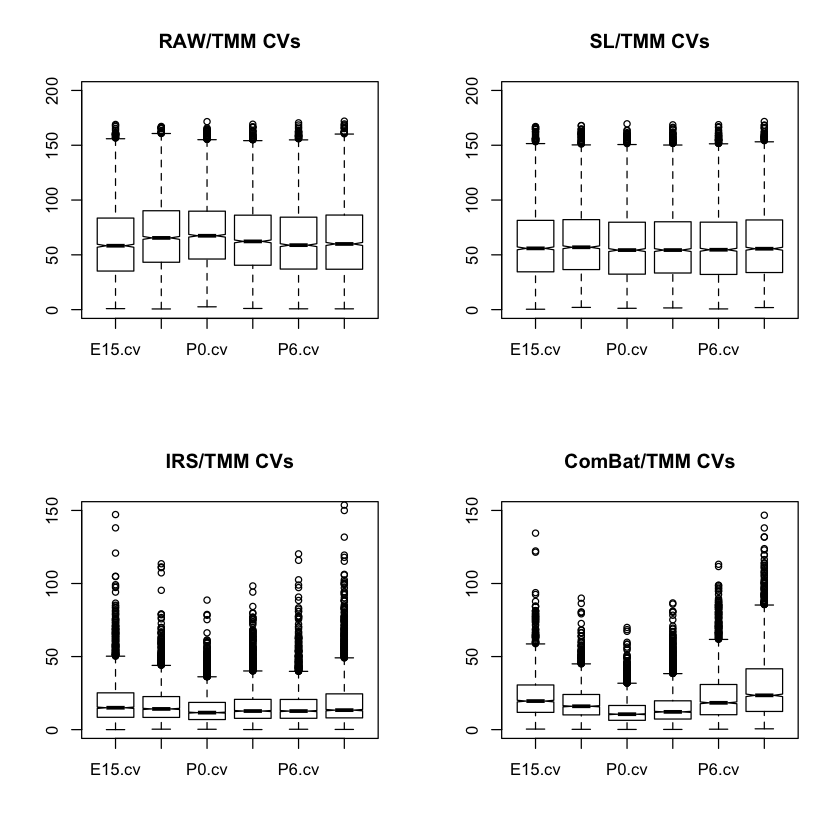

In [21]:
# get CVs and averages
list_raw <- make_CVs(data_raw_tmm)
list_sl <- make_CVs(data_sl_tmm)
list_irs <- make_CVs(data_irs_tmm)
list_combat <- make_CVs(data_combat_tmm)

# compare CV distributions
par(mfrow = c(2, 2))
boxplot(list_raw[[3]], notch = TRUE, main = "RAW/TMM CVs", ylim = c(0, 200))
boxplot(list_sl[[3]], notch = TRUE, main = "SL/TMM CVs", ylim = c(0, 200))
boxplot(list_irs[[3]], notch = TRUE, main = "IRS/TMM CVs", ylim = c(0, 150))
boxplot(list_combat[[3]], notch = TRUE, main = "ComBat/TMM CVs", ylim = c(0, 150))

In [22]:
# print out the average median CVs (in %)
(raw_med_cv <- round(mean(apply(list_raw[[3]], 2, median)), 2))
(sl_med_cv <- round(mean(apply(list_sl[[3]], 2, median)), 2))
(irs_med_cv <- round(mean(apply(list_irs[[3]], 2, median)),2))
(combat_med_cv <- round(mean(apply(list_combat[[3]], 2, median)), 2))

[1] 62.03

[1] 55.29

[1] 13.26

[1] 16.68

## IRS and ComBat finally seem better
Single factor normalization methods (SL and TMM) do not do anything to reconcile data between different TMT experiments at the **individual** protein level. The averages of the median CVs are 62% and 55% for the raw and SL data, respectively. Both IRS and ComBat dramatically lower the median CVs - to 13% and 16%, respectively. 

The IRS method is also clearly better than ComBat for TMT data. ComBat is more complicated than IRS, which is a very specific correction based on the simple idea that if you measure the exact same thing at different times, you should get the same values. Most of the time in genomics, the data you want to do differential expression (DE) testing on and the data used to estimate batch effects are the same. It can be better to incorporate batch factors into the statistical modeling rather than removing batch effects before doing the DE testing. However, with IRS we have independent data (the pooled standard channels) for the batch corrections and different data for the DE testing. 

### Combine the MDS plots and CV distribution plots to summarize what we have learned so far.

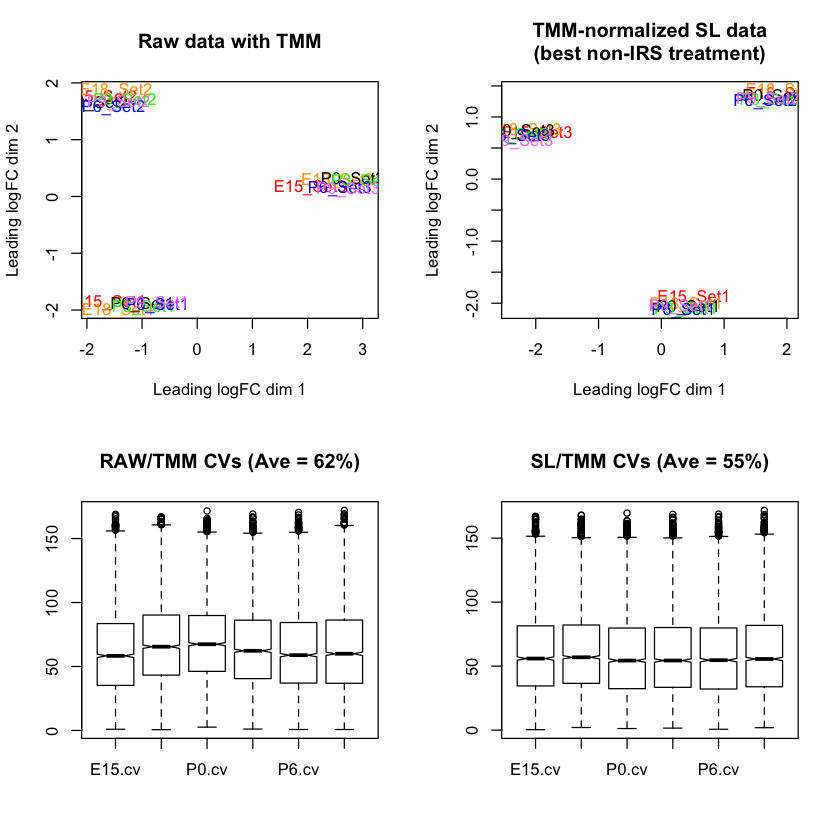

In [23]:
# do a multi-panel plot to see effects before batch corrections
par(mfrow = c(2,2))
plotMDS(log2(data_raw_tmm), col = col_vec, main = 'Raw data with TMM')
plotMDS(log2(data_sl_tmm), col = col_vec, main = 'TMM-normalized SL data\n(best non-IRS treatment)')
boxplot(list_raw[[3]], notch = TRUE, main = "RAW/TMM CVs (Ave = 62%)")
boxplot(list_sl[[3]], notch = TRUE, main = "SL/TMM CVs (Ave = 55%)")

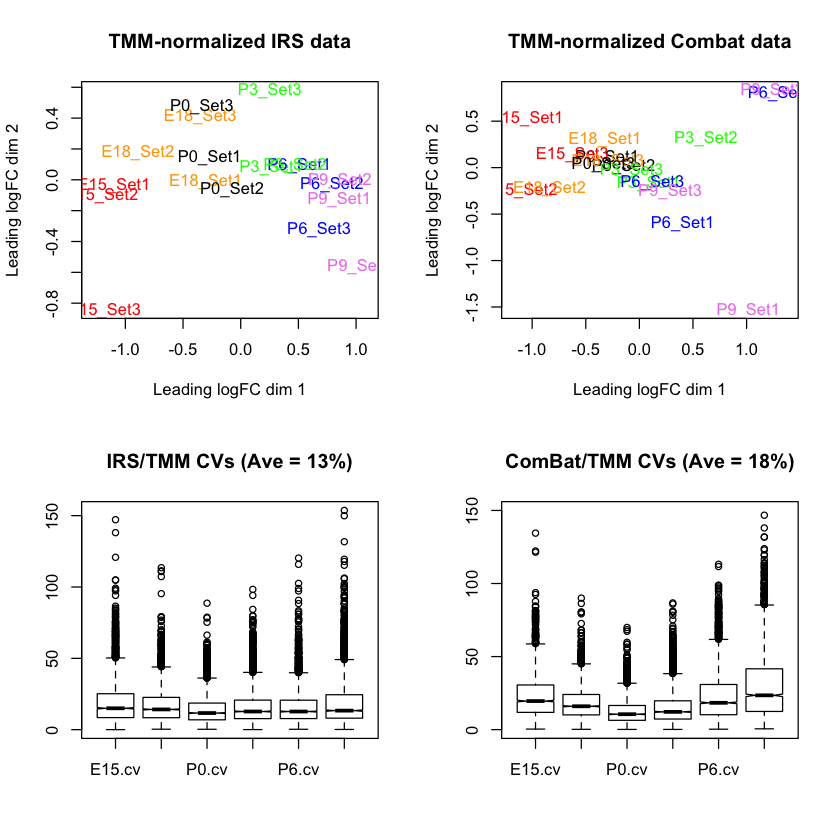

In [24]:
# now after batch corrections (IRS or ComBat)
par(mfrow = c(2, 2))
plotMDS(log2(data_irs_tmm), col = col_vec, main = "TMM-normalized IRS data")
plotMDS(log2(data_combat_tmm), col = col_vec, main = "TMM-normalized Combat data")
boxplot(list_irs[[3]], notch = TRUE, main = "IRS/TMM CVs (Ave = 13%)")
boxplot(list_combat[[3]], notch = TRUE, main = "ComBat/TMM CVs (Ave = 18%)", ylim = c(0, 150))
par(mfrow = c(1, 1)) # reset to default

## Removing TMT experiment batch effects makes a big difference
Both IRS and ComBat remove the TMT experiment batch effects so that the biological effects can be seen. The variation in the data points (CVs) are also dramatically reduced.

## Let's see what IRS does to each data point
We can dig even a little deeper into the effect that IRS has on the data. We can look at correlation plots of each biological replicate against its other replicates. We will compare the combinations of SL and TMM normalizations, a robust set of single factor normalizations, to those with the additional step of the IRS method. We will have 6 sets of scatter plot matrices, with each scatter plot matrix having 3 biological replicates. There will be 6 sets for SL/TMM and 6 sets for SL/IRS/TMM. We will group by time points, so the IRS effect can be seen more easily.

Warning message:
“package ‘psych’ was built under R version 3.4.4”
Attaching package: ‘psych’

The following object is masked from ‘package:genefilter’:

    AUC

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



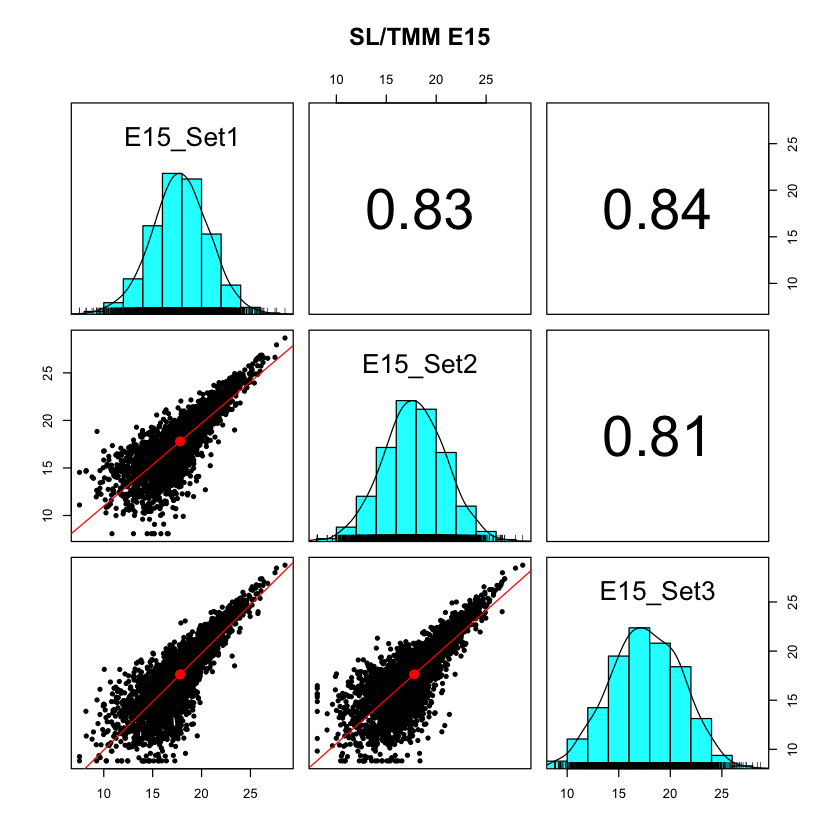

In [25]:
library(psych)
# lets compare the combination of SL and TMM normalizations to SL/IRS/TMM 
# again using the idea that replicates of the same time point should similar
pairs.panels(log2(data_sl_tmm[c(1, 7, 13)]), lm = TRUE, main = "SL/TMM E15")


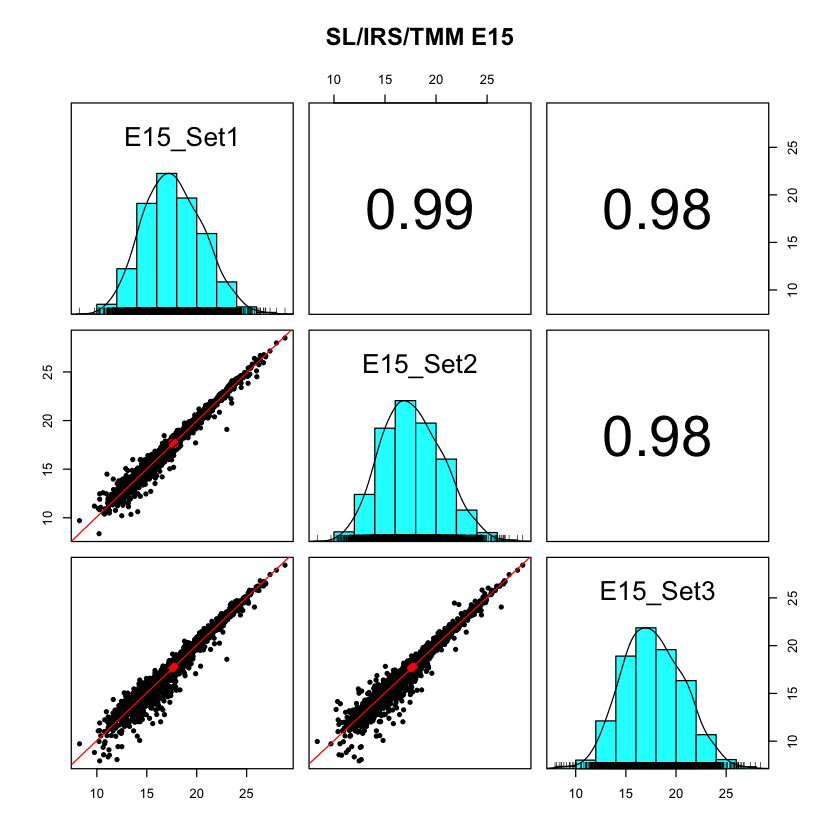

In [26]:
# after IRS
pairs.panels(log2(data_irs_tmm[c(1, 7, 13)]), lm = TRUE, main = "SL/IRS/TMM E15")

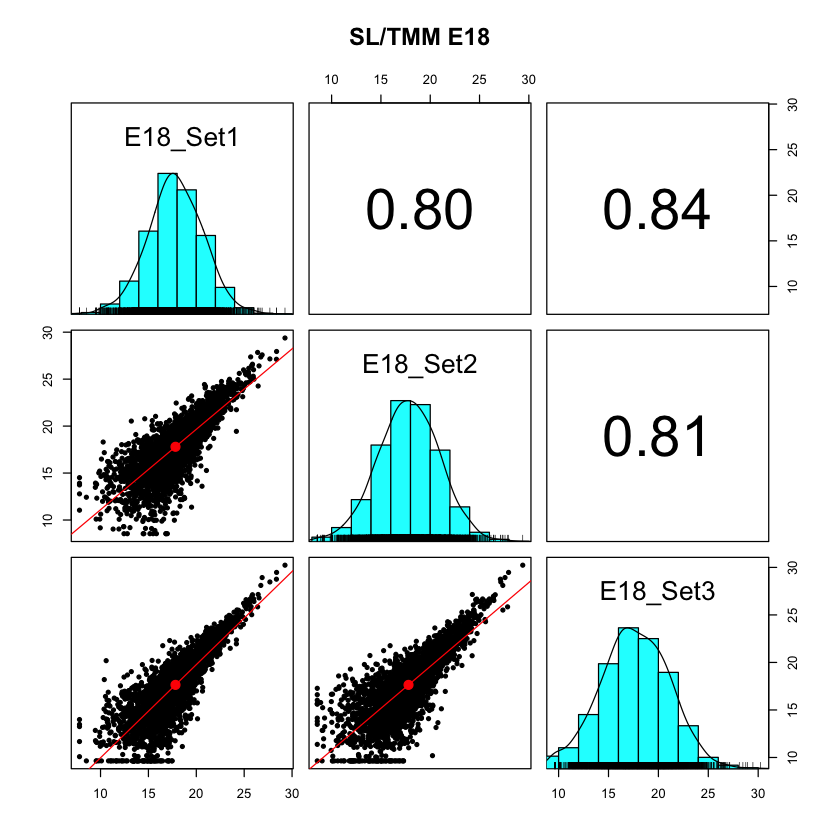

In [27]:
# before IRS
pairs.panels(log2(data_sl_tmm[c(2, 8, 14)]), lm = TRUE, main = "SL/TMM E18")

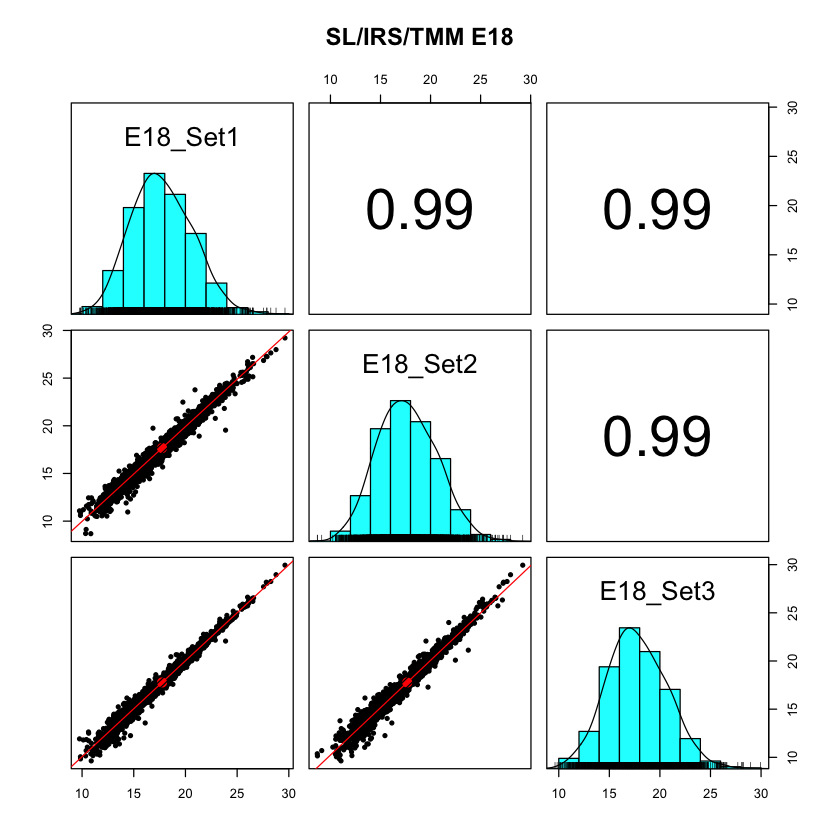

In [28]:
# after IRS
pairs.panels(log2(data_irs_tmm[c(2, 8, 14)]), lm = TRUE, main = "SL/IRS/TMM E18")

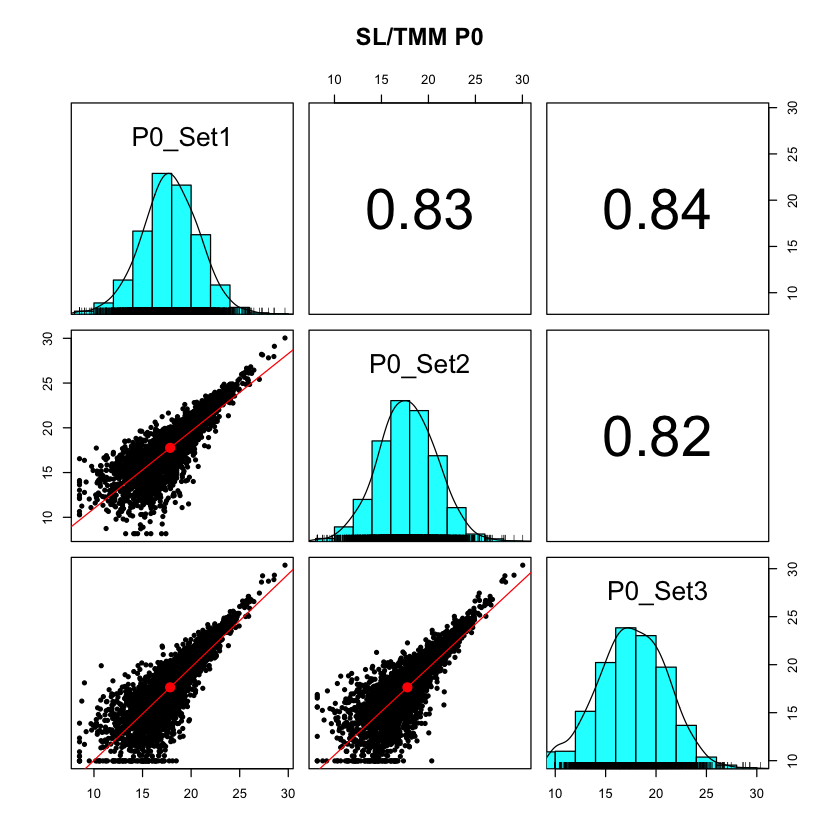

In [29]:
# before IRS
pairs.panels(log2(data_sl_tmm[c(3, 9, 15)]), lm = TRUE, main = "SL/TMM P0")

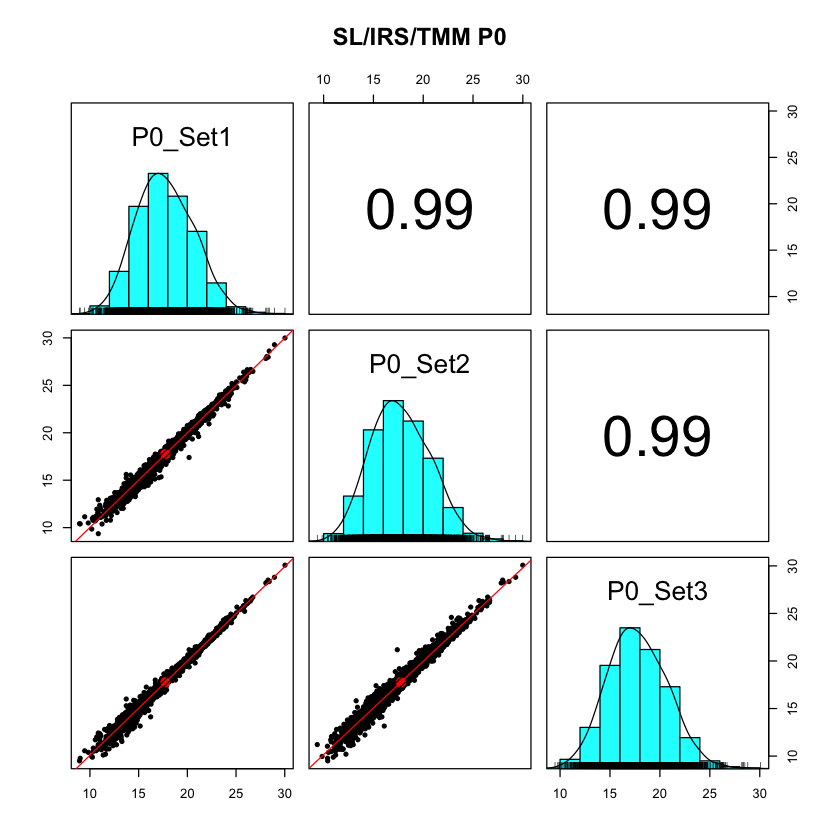

In [30]:
# after IRS
pairs.panels(log2(data_irs_tmm[c(3, 9, 15)]), lm = TRUE, main = "SL/IRS/TMM P0")

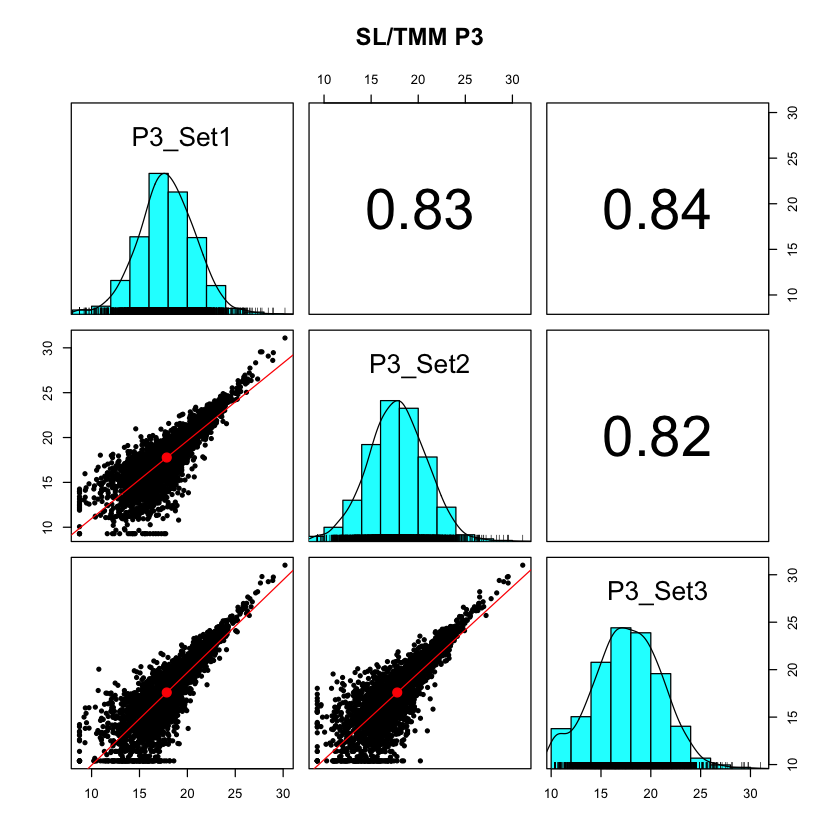

In [31]:
# before IRS
pairs.panels(log2(data_sl_tmm[c(4, 10, 16)]), lm = TRUE, main = "SL/TMM P3")

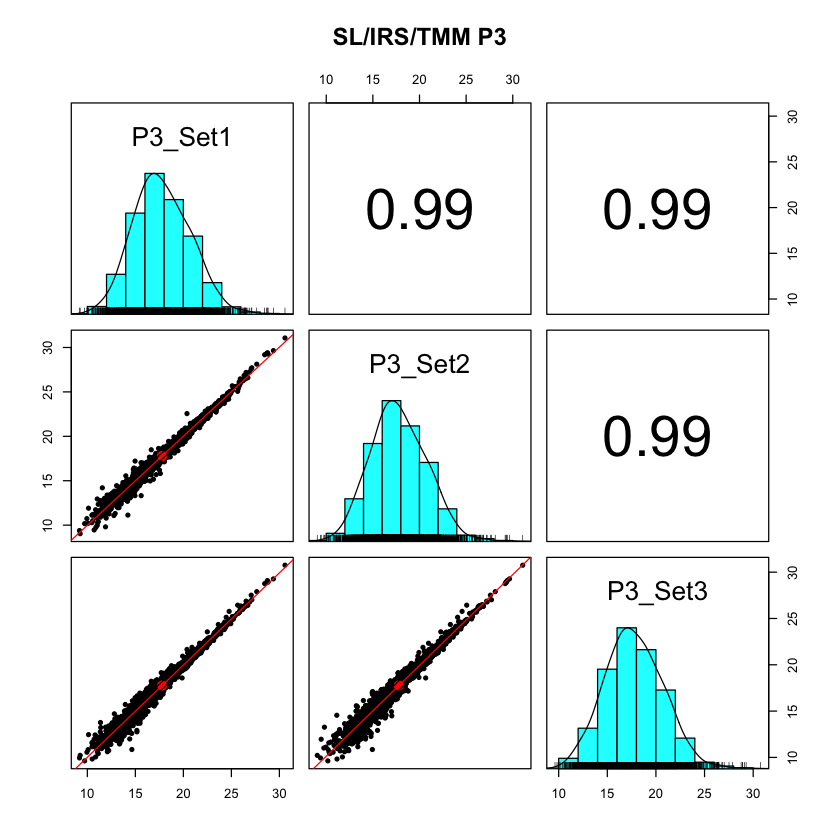

In [32]:
# after IRS
pairs.panels(log2(data_irs_tmm[c(4, 10, 16)]), lm = TRUE, main = "SL/IRS/TMM P3")

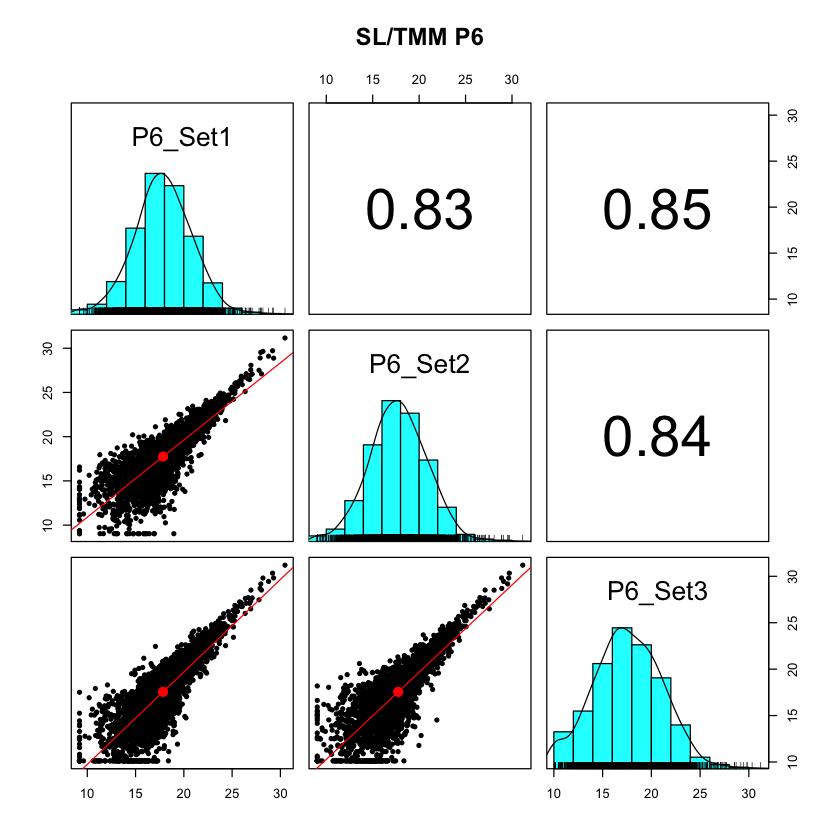

In [33]:
# before IRS
pairs.panels(log2(data_sl_tmm[c(5, 11, 17)]), lm = TRUE, main = "SL/TMM P6")

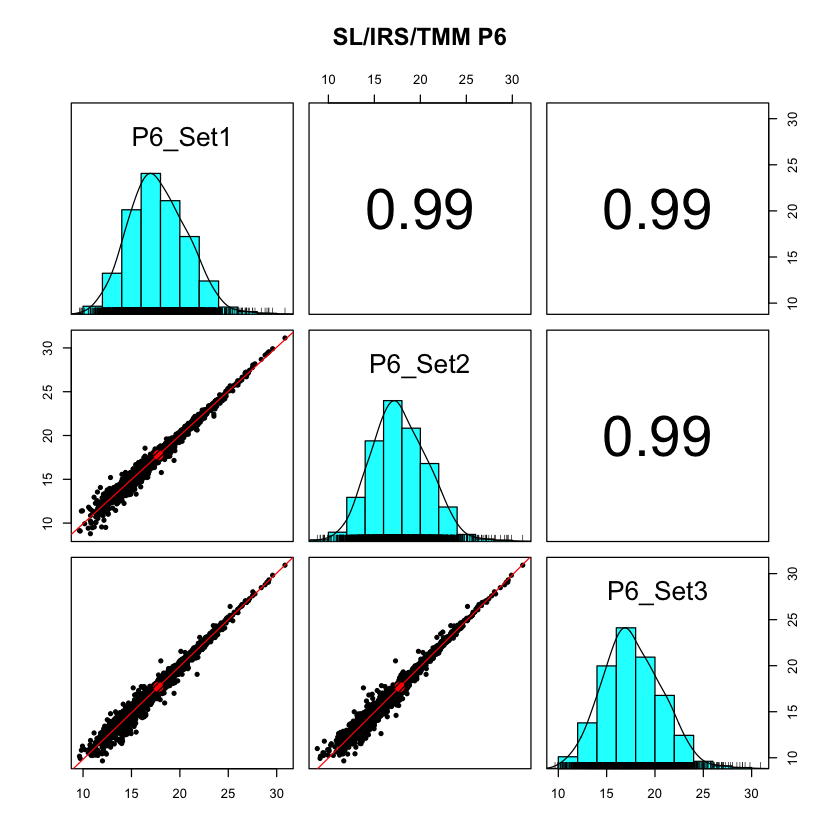

In [34]:
# after IRS
pairs.panels(log2(data_irs_tmm[c(5, 11, 17)]), lm = TRUE, main = "SL/IRS/TMM P6")

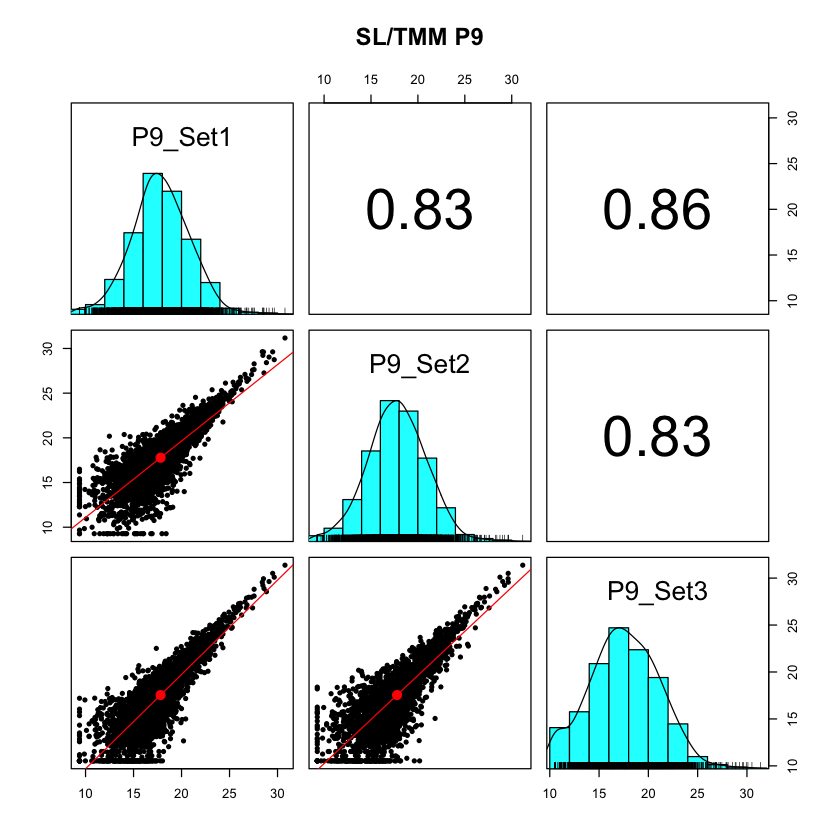

In [35]:
# before IRS
pairs.panels(log2(data_sl_tmm[c(6, 12, 18)]), lm = TRUE, main = "SL/TMM P9")

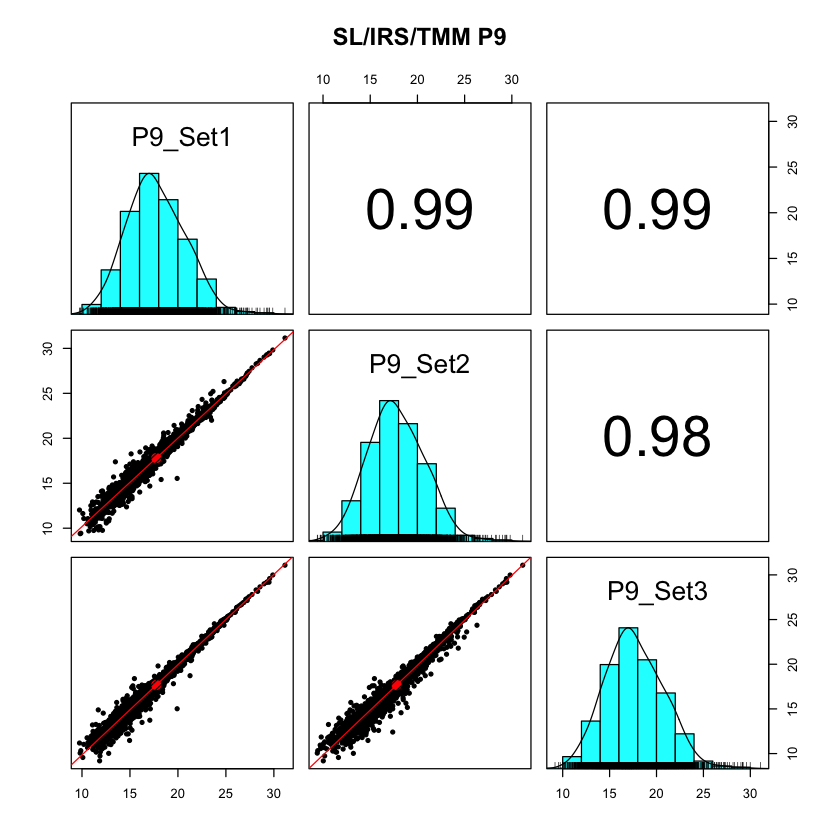

In [36]:
# after IRS
pairs.panels(log2(data_irs_tmm[c(6, 12, 18)]), lm = TRUE, main = "SL/IRS/TMM P9")

## IRS dramatically improves the data 
The scatter between replicates is dramatically reduced in all cases after the IRS corrections. Correlation coefficients, shapes of density plots, and scatter in the scatter plots are all improved. IRS is critically important in analyses of multi-TMT experiments.

## Summary so far
Different TMT experiments are, at some level, a lot like batch effects in genomic studies. Normalizations that cannot remove batch effects (SL and TMM) will not be able to remove as much measurement variability. The large protein CVs will greatly limit the ability to measure the biological differences of interest.

Both IRS and ComBat were capable of removing the dependence of the data on the TMT experiments. The IRS method is very simple and well behaved. It clearly outperforms ComBat using fewer assumptions. This lens study does not have a particularly favorable study design to leverage the power of IRS, and IRS performance might have been better had pooled standard channels been used.

## What is next?

What we really care about in these experiments are the final results. Measuring the expression levels of 3155 proteins over 18 samples is really quite impressive, and the current generation of isobaric labeling marks a significant advance in quantitative proteomics. Despite some clever combining of a much larger number of PSMs into a greatly reduced set of proteins, we are still left with a time course experiment of 6 time points (with 3 replicates) for 3155 proteins. That will require statistical software designed for these complicated 'omics datasets. Luckily, there are genomics packages designed to do just that: limma, edgeR, and DESeq2. We will use one of those tools, edgeR, on this data and see how using or not using IRS affects statistical testing results. This exploration of normalizations has gotten too long, so we will explore statistical testing in the next notebook.

<br>

In [37]:
# let's log the R session
sessionInfo()

R version 3.4.3 (2017-11-30)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS High Sierra 10.13.4

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_1.8.3.3       sva_3.26.0          BiocParallel_1.12.0
 [4] genefilter_1.60.0   mgcv_1.8-23         nlme_3.1-131.1     
 [7] edgeR_3.20.9        limma_3.34.9        forcats_0.3.0      
[10] stringr_1.3.0       dplyr_0.7.4         purrr_0.2.4        
[13] readr_1.1.1         tidyr_0.8.0         tibble_1.4.2       
[16] ggplot2_2.2.1       tidyverse_1.2.1    

loaded via a namespace (and not attached):
 [1] Biobase_2.38.0       httr_1.3.1           splines_3.4.3       
 [4] bit64_